# CMS Open Payments Anomaly Detection

**Project:** AAI-540 Machine Learning Operations - Final Team Project  
**Dataset:** CMS Open Payments Program Year 2024 General Payments  
**Objective:** End-to-end pipeline for detecting anomalous healthcare payment patterns

## Team Members - Group 3
1. Swapnil Patil
2. Jamshed Nabizada
3. Tej Singh Bahadur

## Table of Contents

### Setup & Configuration
- [1. Environment Setup](#1-environment-setup)
- [2. AWS Configuration & Datalake Setup](#2-aws-configuration--datalake-setup)

### Data Preparation
- [3. Data Loading & Exploration](#3-data-loading--exploration)
- [4. Data Cleaning & Preprocessing](#4-data-cleaning--preprocessing)

### Analysis & Features
- [5. Exploratory Data Analysis](#5-exploratory-data-analysis)
  - Payment Statistics
  - Recipient Type Analysis
  - State-Level Analysis
  - Temporal Trend Analysis
- [6. Feature Engineering](#6-feature-engineering)
  - Data Splitting
  - Historical Features
  - Risk Indicators

### Model Training
- [7. Isolation Forest Model Training](#7-isolation-forest-model-training)
  - Data Preparation
  - Model Training
  - Anomaly Detection
  - Performance Evaluation
- [8. Autoencoder Model Training](#8-autoencoder-model-training)
  - Architecture Design
  - Training with Early Stopping
  - Reconstruction Error Analysis
  - Visualization
- [9. XGBoost Model Training](#9-xgboost-model-training)
  - Pseudo-Label Generation
  - Model Configuration
  - Training & Evaluation
  - Feature Importance

### Optimization & Deployment
- [10. Hyperparameter Tuning](#10-hyperparameter-tuning)
  - Grid Search
  - Randomized Search
  - Model Comparison
- [11. Model Deployment to SageMaker](#11-model-deployment-to-sagemaker)
  - Model Packaging
  - Inference Script
  - Endpoint Deployment
  - Testing & Validation

---

## 1. Environment Setup

In [1]:
!pip install -r ../requirements.txt -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import joblib
import tarfile
import sys
from pathlib import Path
from datetime import datetime

import boto3
import sagemaker
import awswrangler as wr
from pyathena import connect
from sagemaker import get_execution_role
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, roc_auc_score
from scipy.stats import randint, uniform

from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

parent_dir = Path.cwd().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

from utils.visualizations import PaymentVisualizer, ModelVisualizer

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

visualizer = PaymentVisualizer()
model_viz = ModelVisualizer()

print("Environment setup complete")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


2026-02-15 19:58:11.200002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Environment setup complete


## 2. AWS Configuration & Datalake Setup

In [3]:
boto_session = boto3.Session()
region = boto_session.region_name
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity().get('Account')

s3_client = boto3.client('s3', region_name=region)
s3_resource = boto3.resource('s3')

dataset_file_name = "lightdataset.csv"
bucket = f"cmsopenpaymentsystemslight"
cms_data_prefix = "cms-open-payments-light"
database_name = "cms_open_payments_light"

raw_data_prefix = f"{cms_data_prefix}/raw"
parquet_data_prefix = f"{cms_data_prefix}/parquet"

s3_raw_path = f"s3://{bucket}/{raw_data_prefix}"
s3_parquet_path = f"s3://{bucket}/{parquet_data_prefix}"
s3_athena_staging = f"s3://{bucket}/athena/staging"

table_name_csv = "general_payments_csv"
table_name_parquet = "general_payments_parquet"

print(f"Region: {region} | Bucket: {bucket} | Database: {database_name}")

Region: us-east-1 | Bucket: cmsopenpaymentsystemslight | Database: cms_open_payments_light


In [4]:
def check_bucket_exists(bucket_name):
    try:
        s3_client.head_bucket(Bucket=bucket_name)
        return True
    except:
        return False

def ensure_bucket_exists(bucket_name, region):
    try:
        if check_bucket_exists(bucket_name):
            print(f"Bucket exists: {bucket_name}")
            return True
        if region == 'us-east-1':
            s3_client.create_bucket(Bucket=bucket_name)
        else:
            s3_client.create_bucket(
                Bucket=bucket_name,
                CreateBucketConfiguration={'LocationConstraint': region}
            )
        print(f"Created bucket: {bucket_name}")
        return True
    except Exception as e:
        print(f"Error with bucket: {str(e)}")
        return False

ensure_bucket_exists(bucket, region)

Bucket exists: cmsopenpaymentsystemslight


True

In [5]:
athena_conn = connect(region_name=region, s3_staging_dir=s3_athena_staging)

create_db_query = f"CREATE DATABASE IF NOT EXISTS {database_name}"
pd.read_sql(create_db_query, athena_conn)
print(f"Database created: {database_name}")

Database created: cms_open_payments_light


In [6]:
# Check if dataset file exists in S3
s3_raw_file_key = f"{raw_data_prefix}/{dataset_file_name}"
s3_raw_file_path = f"{s3_raw_path}/{dataset_file_name}"

try:
    s3_response = s3_client.head_object(Bucket=bucket, Key=s3_raw_file_key)
    file_size_mb = s3_response['ContentLength'] / (1024**2)
    print(f"Dataset file found in S3: {s3_raw_file_path}")
    print(f"File size: {file_size_mb:.2f} MB")
    print(f"Last modified: {s3_response['LastModified']}")
except:
    print(f"Dataset file not found in S3: {s3_raw_file_path}")
    print(f"Please upload {dataset_file_name} to S3 bucket {bucket} at prefix {raw_data_prefix}/")
    print(f"Upload command: aws s3 cp ../data/{dataset_file_name} s3://{bucket}/{raw_data_prefix}/")

Dataset file found in S3: s3://cmsopenpaymentsystemslight/cms-open-payments-light/raw/lightdataset.csv
File size: 523.35 MB
Last modified: 2026-01-30 05:06:44+00:00


In [7]:
# Verify S3 file is accessible for Athena table creation
try:
    s3_client.head_object(Bucket=bucket, Key=s3_raw_file_key)
    print(f"S3 dataset verified: {s3_raw_file_path}")
    print(f"Ready for Athena table creation")
except Exception as e:
    print(f"ERROR: Cannot access dataset file in S3")
    print(f"Please ensure {dataset_file_name} is uploaded to s3://{bucket}/{raw_data_prefix}/")
    print(f"Error details: {e}")
    raise

S3 dataset verified: s3://cmsopenpaymentsystemslight/cms-open-payments-light/raw/lightdataset.csv
Ready for Athena table creation


In [8]:
# Check if CSV table already exists and has data
try:
    check_csv_table = f"SELECT COUNT(*) as cnt FROM {database_name}.{table_name_csv} LIMIT 1"
    csv_result = pd.read_sql(check_csv_table, athena_conn)
    csv_exists = True
    print(f"CSV table '{table_name_csv}' already exists")
except Exception as e:
    csv_exists = False
    print(f"CSV table '{table_name_csv}' does not exist, will create it")

if not csv_exists:
    # Read schema from S3 dataset file
    df_schema = pd.read_csv(s3_raw_file_path, nrows=1000)

    TEXT_COLUMN_PATTERNS = [
        '_name', '_address', '_city', '_state', '_country', '_province',
        '_zip', '_postal', '_code', '_ccn', '_npi', '_id', 
        'first_name', 'last_name', 'middle_name', 'suffix',
        'street', 'covered_recipient_type', 'nature_of', 'form_of',
        'physician_specialty', 'recipient_primary_', 'business_street',
        'teaching_hospital', 'applicable_manufacturer', 'making_payment'
    ]

    def get_athena_type(col_name, dtype):
        col_lower = col_name.lower()
        if any(pattern in col_lower for pattern in TEXT_COLUMN_PATTERNS):
            return 'STRING'
        if pd.api.types.is_integer_dtype(dtype):
            return 'BIGINT'
        elif pd.api.types.is_float_dtype(dtype):
            return 'DOUBLE'
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return 'TIMESTAMP'
        else:
            return 'STRING'

    columns_def = []
    for col in df_schema.columns:
        athena_type = get_athena_type(col, df_schema[col].dtype)
        columns_def.append(f"`{col}` {athena_type}")

    columns_str = ',\n    '.join(columns_def)

    create_table_query = f"""
    CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name_csv} (
        {columns_str}
    )
    ROW FORMAT DELIMITED
    FIELDS TERMINATED BY ','
    LINES TERMINATED BY '\\n'
    STORED AS TEXTFILE
    LOCATION '{s3_raw_path}/'
    TBLPROPERTIES (
        'skip.header.line.count'='1',
        'serialization.null.format'=''
    )
    """

    pd.read_sql(create_table_query, athena_conn)
    print(f"Table created: {table_name_csv}")
else:
    print(f"Skipping CSV table creation - table already exists")

CSV table 'general_payments_csv' already exists
Skipping CSV table creation - table already exists


In [9]:
# Check if Parquet table already exists and has data
try:
    check_parquet_query = f"SELECT COUNT(*) as row_count FROM {database_name}.{table_name_parquet}"
    parquet_result = pd.read_sql(check_parquet_query, athena_conn)
    parquet_row_count = parquet_result['row_count'][0]
    
    if parquet_row_count > 0:
        print(f"Parquet table '{table_name_parquet}' already exists with {parquet_row_count:,} rows")
        print("Skipping Parquet conversion - data already loaded")
        parquet_exists = True
    else:
        print(f"Parquet table '{table_name_parquet}' exists but is empty")
        parquet_exists = False
except Exception as e:
    print(f"Parquet table '{table_name_parquet}' does not exist or error checking: {e}")
    print("Will create Parquet table")
    parquet_exists = False

Parquet table 'general_payments_parquet' already exists with 1,000,000 rows
Skipping Parquet conversion - data already loaded


In [10]:
if not parquet_exists:
    columns_query = f"SELECT * FROM {database_name}.{table_name_csv} LIMIT 1"

    force_string_cols = [
        'teaching_hospital_ccn', 'teaching_hospital_id',
        'applicable_manufacturer_or_applicable_gpo_making_payment_id',
        'covered_recipient_npi', 'covered_recipient_profile_id',
        'physician_profile_id', 'recipient_zip_code', 'recipient_postal_code'
    ]

    columns_df = pd.read_sql(columns_query, athena_conn)
    columns = columns_df.columns.tolist()

    if 'program_year' in columns:
        columns.remove('program_year')

    formatted_columns = []
    for col in columns:
        if col in force_string_cols or any(pattern in col.lower() for pattern in 
            ['_name', '_address', '_city', '_id', '_npi', '_ccn', 'zip', 'postal']):
            formatted_columns.append(f'CAST("{col}" AS VARCHAR) AS "{col}"')
        else:
            formatted_columns.append(f'"{col}"')

    columns_str = ',\n '.join(formatted_columns)

    create_parquet_query = f"""
    CREATE TABLE {database_name}.{table_name_parquet}
    WITH (
        format = 'PARQUET',
        parquet_compression = 'SNAPPY',
        external_location = '{s3_parquet_path}/',
        partitioned_by = ARRAY['program_year']
    )
    AS
    SELECT 
        {columns_str},
        '2024' as program_year
    FROM {database_name}.{table_name_csv}
    """

    print("Converting to Parquet...")
    pd.read_sql(create_parquet_query, athena_conn)
    print(f"Parquet table created: {table_name_parquet}")
else:
    print("Skipping Parquet conversion - using existing data")

Skipping Parquet conversion - using existing data


In [11]:
result = pd.read_sql(
    f"SELECT COUNT(*) as row_count FROM {database_name}.{table_name_parquet}",
    athena_conn
)
print(f"Data verified: {result['row_count'][0]:,} rows")

Data verified: 1,000,000 rows


## 3. Data Loading & Exploration

In [12]:
sample_size = 1_000_000

sample_query = f"""
SELECT *
FROM {database_name}.{table_name_parquet}
LIMIT {sample_size}
"""

df = wr.athena.read_sql_query(
    sql=sample_query,
    database=database_name,
    ctas_approach=False
)

print(f"Data loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
display(df.head(3))

2026-02-15 19:58:37,773	WARNING services.py:2070 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1909428224 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=2.37gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2026-02-15 19:58:38,851	INFO worker.py:1852 -- Started a local Ray instance.


Data loaded: 1,000,000 rows, 91 columns


,change_type,covered_recipient_type,teaching_hospital_ccn,teaching_hospital_id,teaching_hospital_name,covered_recipient_profile_id,covered_recipient_npi,covered_recipient_first_name,covered_recipient_middle_name,covered_recipient_last_name,covered_recipient_name_suffix,recipient_primary_business_street_address_line1,recipient_primary_business_street_address_line2,recipient_city,recipient_state,recipient_zip_code,recipient_country,recipient_province,recipient_postal_code,covered_recipient_primary_type_1,covered_recipient_primary_type_2,covered_recipient_primary_type_3,covered_recipient_primary_type_4,covered_recipient_primary_type_5,covered_recipient_primary_type_6,...,indicate_drug_or_biological_or_device_or_medical_supply_2,product_category_or_therapeutic_area_2,name_of_drug_or_biological_or_device_or_medical_supply_2,associated_drug_or_biological_ndc_2,associated_device_or_medical_supply_pdi_2,covered_or_noncovered_indicator_3,indicate_drug_or_biological_or_device_or_medical_supply_3,product_category_or_therapeutic_area_3,name_of_drug_or_biological_or_device_or_medical_supply_3,associated_drug_or_biological_ndc_3,associated_device_or_medical_supply_pdi_3,covered_or_noncovered_indicator_4,indicate_drug_or_biological_or_device_or_medical_supply_4,product_category_or_therapeutic_area_4,name_of_drug_or_biological_or_device_or_medical_supply_4,associated_drug_or_biological_ndc_4,associated_device_or_medical_supply_pdi_4,covered_or_noncovered_indicator_5,indicate_drug_or_biological_or_device_or_medical_supply_5,product_category_or_therapeutic_area_5,name_of_drug_or_biological_or_device_or_medical_supply_5,associated_drug_or_biological_ndc_5,associated_device_or_medical_supply_pdi_5,payment_publication_date,program_year
0,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,1.1049966E7,1.518263342E9,<NA>,<NA>,<NA>,<NA>,1265 UPPER HEMBREE RD,<NA>,ROSWELL,GA,<NA>,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
1,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,1.0512664E7,1.528345469E9,<NA>,<NA>,<NA>,<NA>,103 Allen St,<NA>,Jamestown,NY,14701,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/30/2025,2024
2,NEW,Covered Recipient Non-Physician Practitioner,<NA>,<NA>,<NA>,1.0844269E7,1.760831846E9,<NA>,<NA>,<NA>,<NA>,365 MONTAUK AVE,<NA>,NEW LONDON,CT,<NA>,United States,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,2024


## 4. Data Cleaning & Preprocessing

In [13]:
CORE_PAYMENT_FEATURES = [
    'total_amount_of_payment_usdollars',
    'number_of_payments_included_in_total_amount',
    'date_of_payment'
]

CATEGORICAL_FEATURES = [
    'covered_recipient_type',
    'nature_of_payment_or_transfer_of_value',
    'form_of_payment_or_transfer_of_value',
    'physician_specialty',
    'recipient_state'
]

IDENTIFIER_FEATURES = [
    'covered_recipient_profile_id',
    'covered_recipient_npi',
    'applicable_manufacturer_or_applicable_gpo_making_payment_name'
]

RISK_INDICATOR_FEATURES = [
    'physician_ownership_indicator',
    'third_party_payment_recipient_indicator',
    'product_indicator'
]

all_selected_features = (CORE_PAYMENT_FEATURES + CATEGORICAL_FEATURES + 
                         IDENTIFIER_FEATURES + RISK_INDICATOR_FEATURES)

available_features = [f for f in all_selected_features if f in df.columns]
df_selected = df[available_features].copy()

print(f"Features selected: {df_selected.shape}")

Features selected: (1000000, 12)


In [14]:
if 'total_amount_of_payment_usdollars' in df_selected.columns:
    df_selected['total_amount_of_payment_usdollars'] = pd.to_numeric(
        df_selected['total_amount_of_payment_usdollars'], errors='coerce'
    ).abs()

if 'date_of_payment' in df_selected.columns:
    df_selected['date_of_payment'] = pd.to_datetime(df_selected['date_of_payment'], errors='coerce')

if 'number_of_payments_included_in_total_amount' in df_selected.columns:
    df_selected['number_of_payments_included_in_total_amount'] = pd.to_numeric(
        df_selected['number_of_payments_included_in_total_amount'], errors='coerce'
    ).fillna(1).astype('int64')

indicator_mapping = {'Yes': 1, 'Y': 1, 'No': 0, 'N': 0, 'Unknown': 0}
for col in RISK_INDICATOR_FEATURES:
    if col in df_selected.columns and df_selected[col].dtype == 'object':
        df_selected[col] = df_selected[col].map(indicator_mapping).fillna(0).astype('int64')

if 'recipient_state' in df_selected.columns:
    df_selected['recipient_state'] = df_selected['recipient_state'].str.upper().str.strip()

print("Data types converted")

Data types converted


In [15]:
if 'total_amount_of_payment_usdollars' in df_selected.columns:
    payment_median = df_selected['total_amount_of_payment_usdollars'].median()
    df_selected['total_amount_of_payment_usdollars'].fillna(payment_median, inplace=True)

if 'date_of_payment' in df_selected.columns:
    df_selected['date_of_payment'].fillna(method='ffill', inplace=True)
    df_selected['date_of_payment'].fillna(method='bfill', inplace=True)

for col in df_selected.select_dtypes(include=['object']).columns:
    if df_selected[col].isnull().sum() > 0:
        df_selected[col].fillna("Unknown", inplace=True)

for col in df_selected.select_dtypes(include=[np.number]).columns:
    if df_selected[col].isnull().sum() > 0:
        df_selected[col].fillna(df_selected[col].median(), inplace=True)

print("Missing values handled")

Missing values handled


In [16]:
records_before = len(df_selected)

df_selected = df_selected.drop_duplicates()

if 'total_amount_of_payment_usdollars' in df_selected.columns:
    df_selected = df_selected[df_selected['total_amount_of_payment_usdollars'] > 0]

if 'date_of_payment' in df_selected.columns:
    df_selected = df_selected[df_selected['date_of_payment'].notnull()]

if 'covered_recipient_profile_id' in df_selected.columns:
    df_selected = df_selected[df_selected['covered_recipient_profile_id'].notnull()]

df_selected = df_selected.reset_index(drop=True)
records_after = len(df_selected)

print(f"Records: {records_after:,} | Removed: {records_before - records_after:,} | Retention: {records_after/records_before*100:.2f}%")

df = df_selected.copy()

Records: 997,362 | Removed: 2,638 | Retention: 99.74%


In [17]:
payment_date_col = 'date_of_payment'
if payment_date_col in df.columns:
    df['payment_year'] = df[payment_date_col].dt.year
    df['payment_month'] = df[payment_date_col].dt.month
    df['payment_quarter'] = df[payment_date_col].dt.quarter
    df['payment_dayofweek'] = df[payment_date_col].dt.dayofweek
    df['is_weekend'] = (df[payment_date_col].dt.dayofweek >= 5).astype('int64')

print("Temporal features created")

Temporal features created


## 5. Exploratory Data Analysis

In [18]:
payment_col = 'total_amount_of_payment_usdollars'

if payment_col in df.columns:
    payment_stats = df[payment_col].describe()
    
    print(f"Payment Statistics:")
    print(f"Count: {payment_stats['count']:,.0f} | Mean: ${payment_stats['mean']:,.2f} | Median: ${payment_stats['50%']:,.2f}")
    print(f"Min: ${payment_stats['min']:,.2f} | Max: ${payment_stats['max']:,.2f}")
    print(f"Skewness: {df[payment_col].skew():.2f}")

Payment Statistics:
Count: 997,362 | Mean: $4,511,992.08 | Median: $20.02
Min: $0.01 | Max: $100,000,966,856.00
Skewness: 148.86


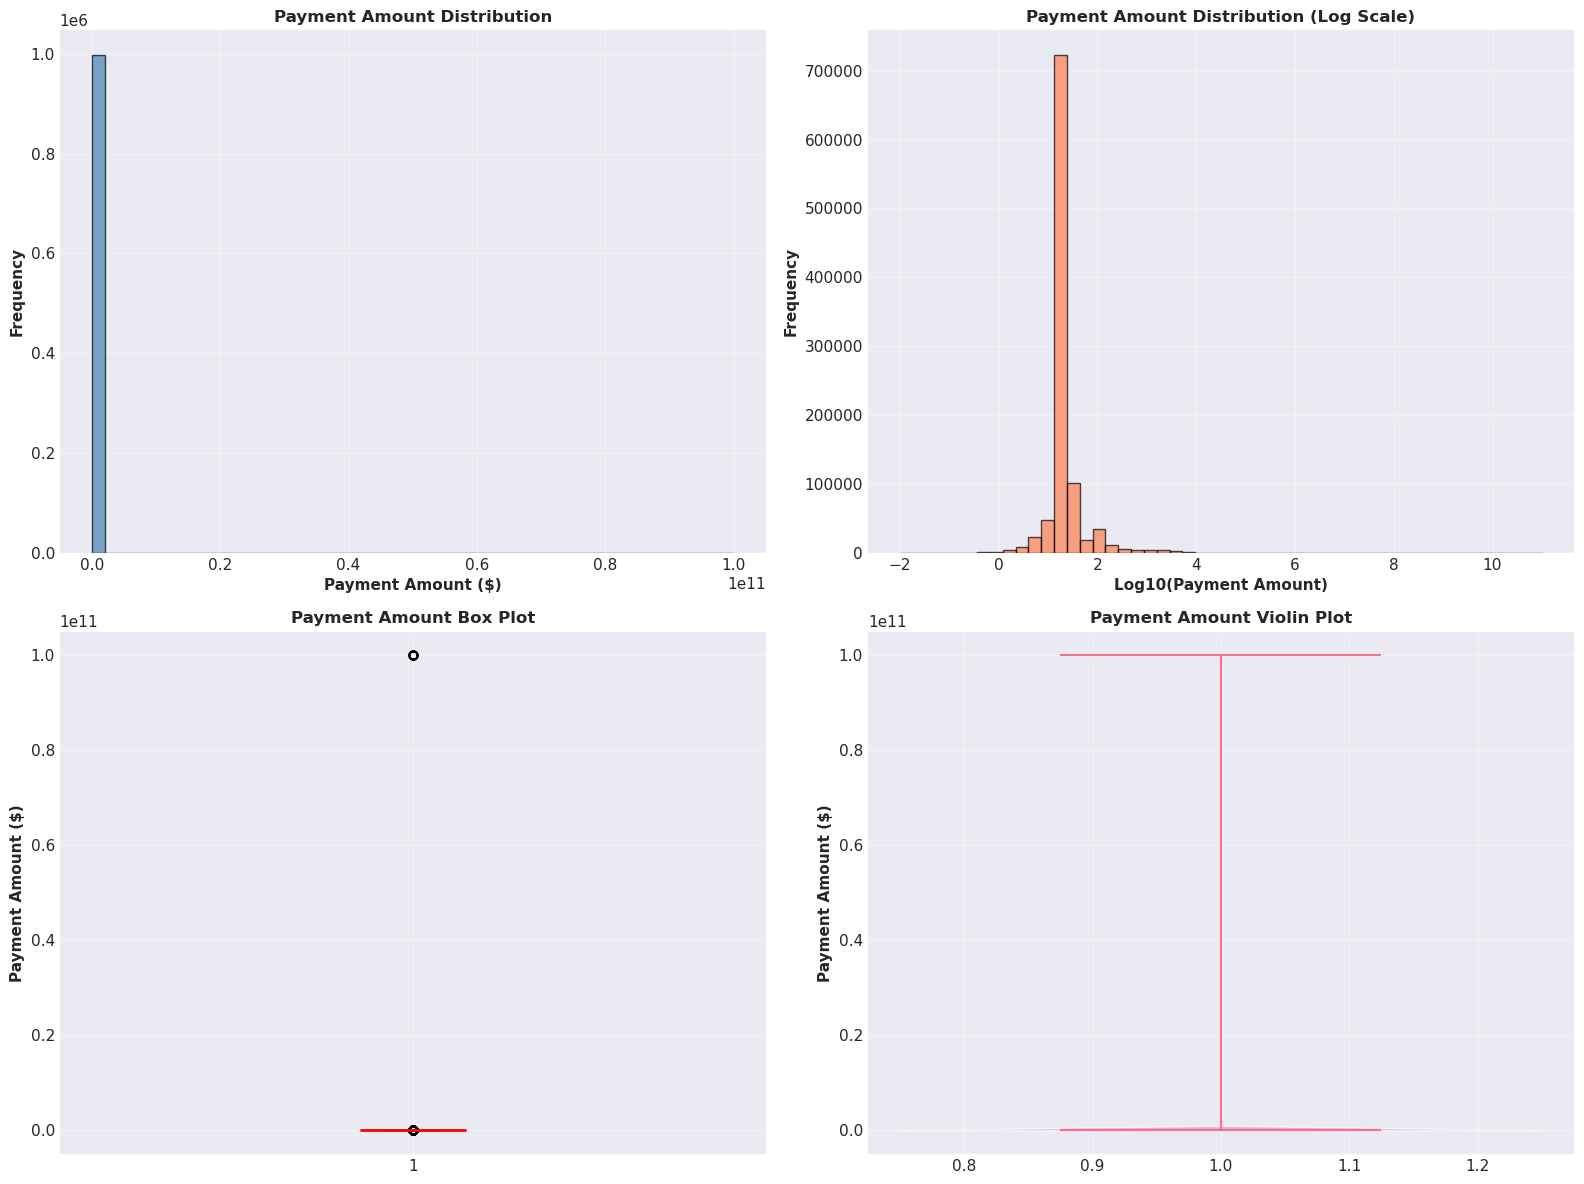

In [19]:
visualizer.plot_payment_distribution_detailed(df, payment_col=payment_col)
plt.show()

In [20]:
recipient_type_col = 'covered_recipient_type'

if recipient_type_col in df.columns and payment_col in df.columns:
    type_stats = df.groupby(recipient_type_col)[payment_col].agg([
        'count', 'sum', 'mean', 'median'
    ]).round(2)
    type_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    type_stats = type_stats.sort_values('Total ($)', ascending=False)
    display(type_stats)

,Count,Total ($),Mean ($),Median ($)
covered_recipient_type,,,,
Covered Recipient Physician,641852,2800074825004.61,4362492.95,20.02
Covered Recipient Non-Physician Practitioner,355510,1700014614929.78,4781903.79,20.02


In [21]:
state_col = 'recipient_state'

if state_col in df.columns and payment_col in df.columns:
    state_stats = df.groupby(state_col)[payment_col].agg([
        'count', 'sum', 'mean'
    ]).round(2)
    state_stats.columns = ['Count', 'Total ($)', 'Mean ($)']
    state_stats = state_stats.sort_values('Total ($)', ascending=False).head(10)
    display(state_stats)

,Count,Total ($),Mean ($)
recipient_state,,,
"06360""",9,800002923584.02,88889213731.56
7B,13,800000017627.10,61538462894.39
420,6,400000001071.04,66666666845.17
120,9,300000152226.12,33333350247.35
3RD FLOOR,3,200000787634.02,66666929211.34
"""YALE UNIVERSITY",2,200000021166.00,100000010583.00
124,2,200000000402.00,100000000201.00
JOHNS CREEK,1,100000226817.00,100000226817.00
ACB,1,100000216794.00,100000216794.00


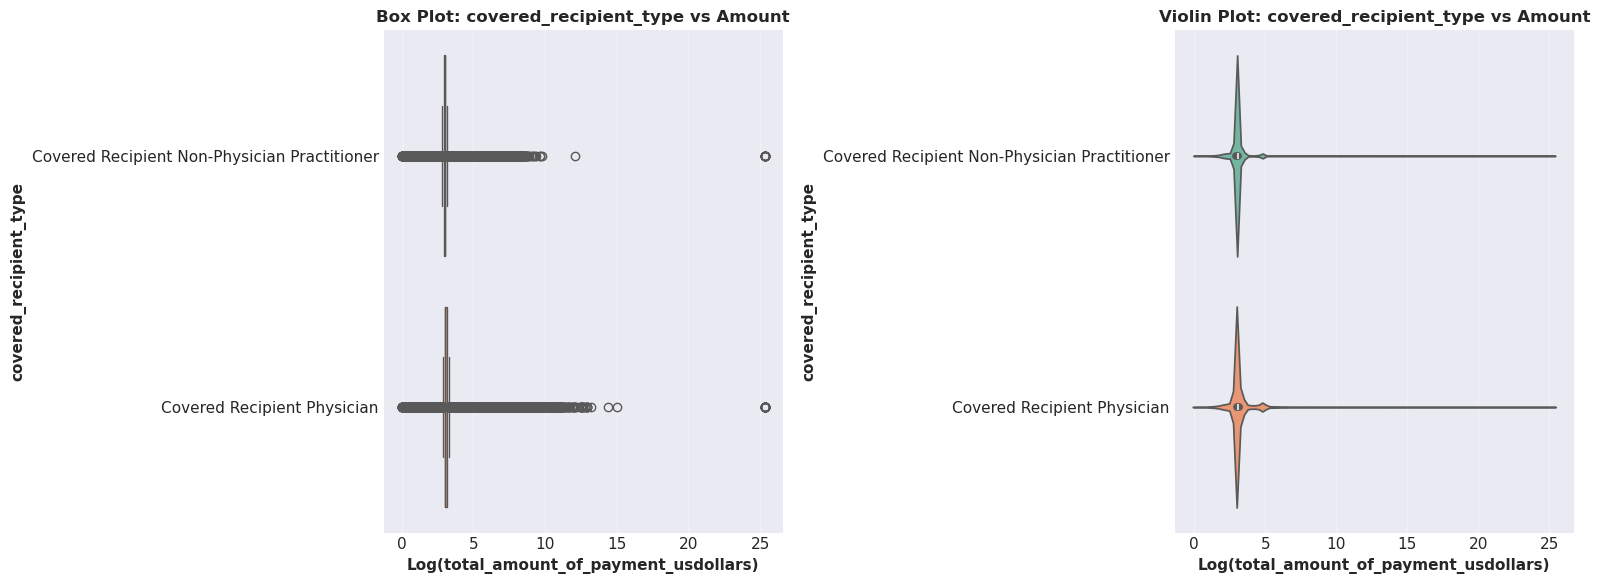

In [22]:
if recipient_type_col in df.columns and payment_col in df.columns:
    visualizer.plot_bivariate_comparison(df, group_col=recipient_type_col, amount_col=payment_col)
    plt.show()

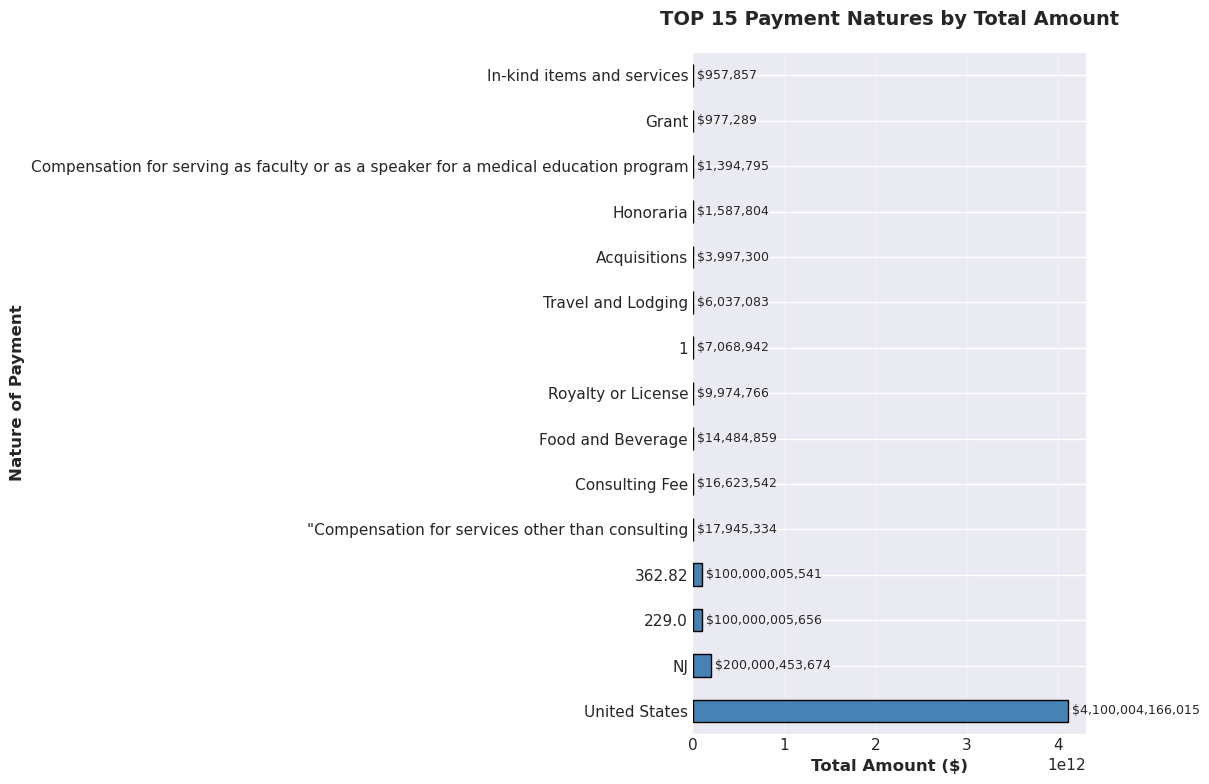

In [23]:
nature_col = 'nature_of_payment_or_transfer_of_value'

if nature_col in df.columns and payment_col in df.columns:
    visualizer.plot_payment_nature_by_total(
        df,
        nature_col=nature_col,
        amount_col=payment_col,
        top_n=15
    )
    plt.show()

### Temporal Trend Analysis

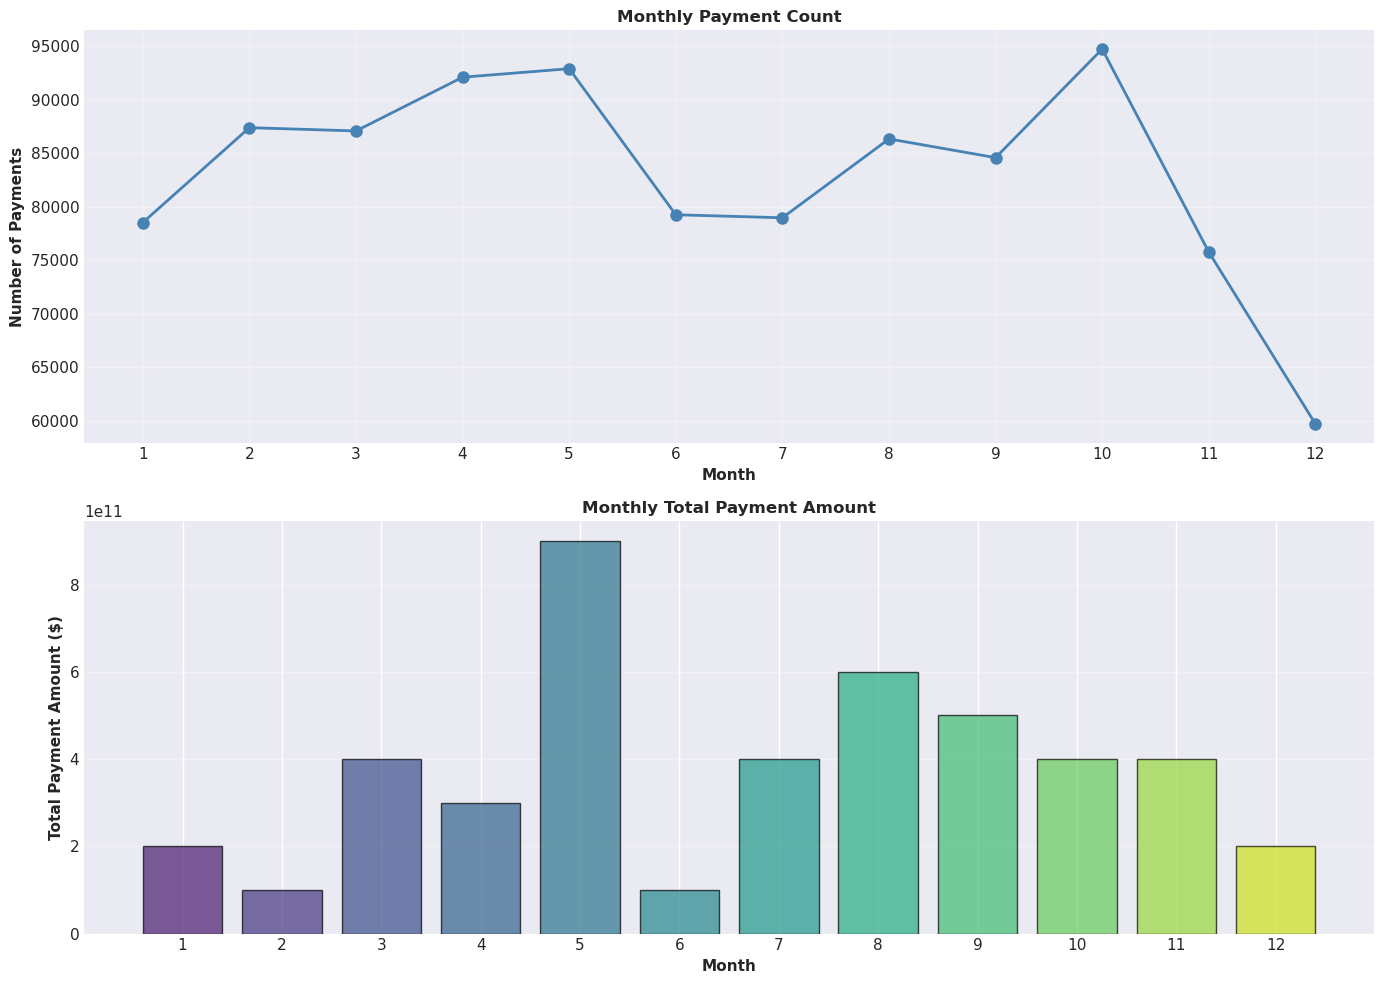

In [24]:
if 'payment_month' in df.columns and payment_col in df.columns:
    visualizer.plot_monthly_trends(df, payment_col=payment_col, month_col='payment_month')
    plt.show()

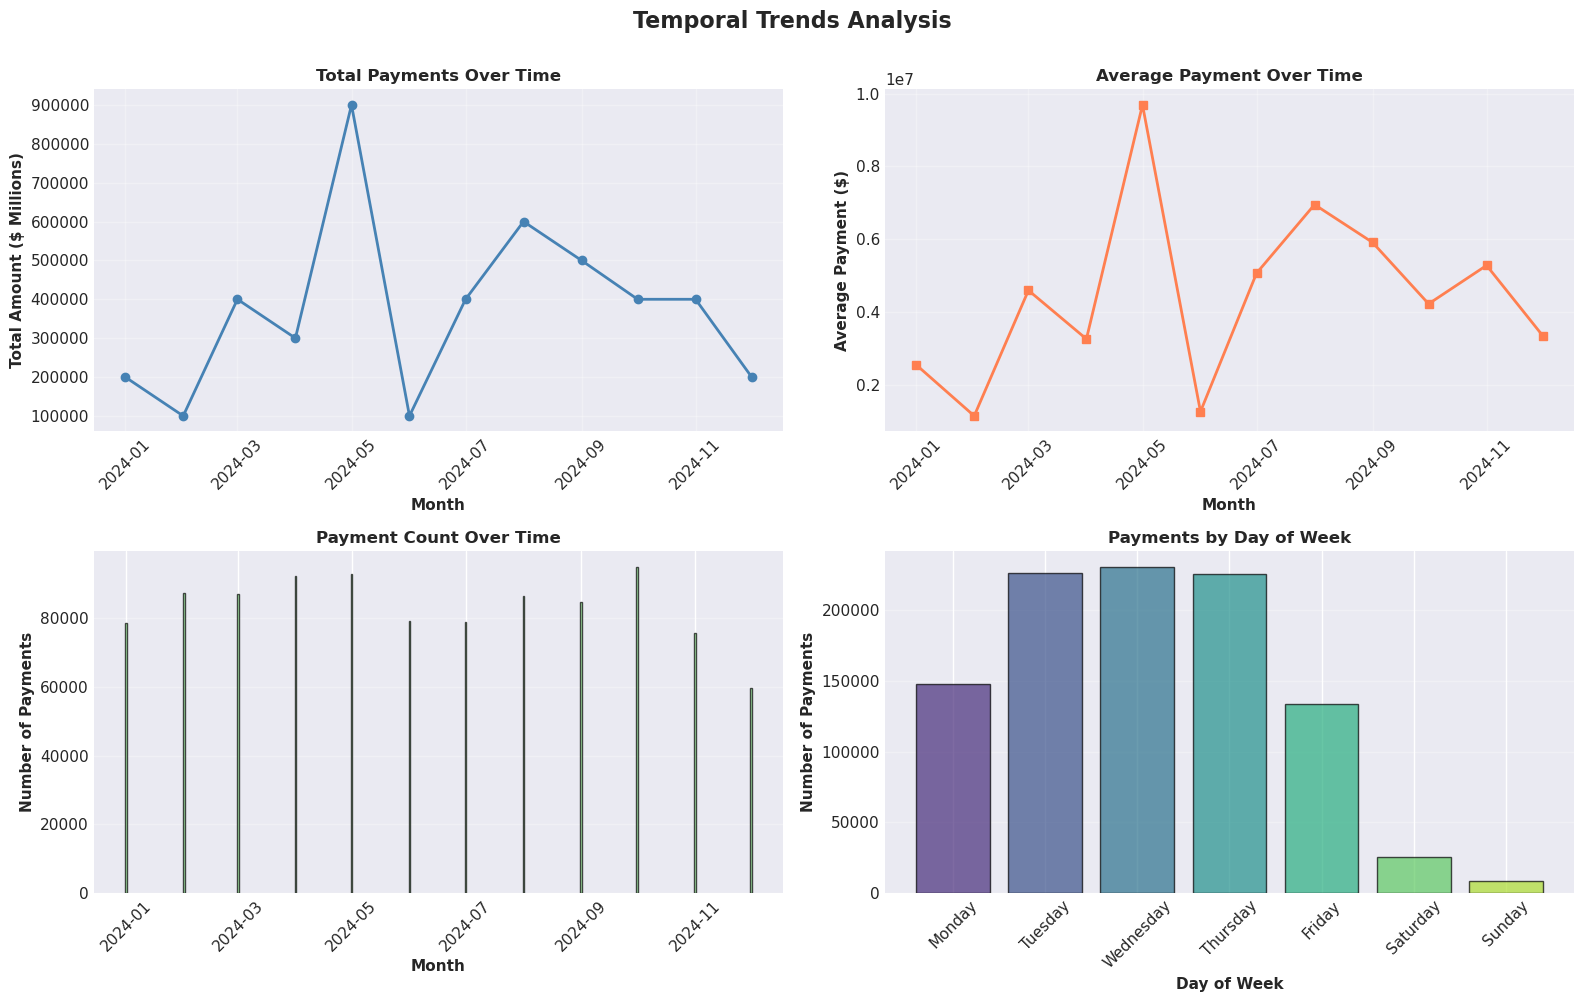

In [25]:
if 'date_of_payment' in df.columns and payment_col in df.columns:
    visualizer.plot_temporal_trends(df, date_col='date_of_payment', amount_col=payment_col)
    plt.show()

Quarterly Payment Statistics:


,Count,Total ($),Mean ($),Median ($)
Quarter,,,,
1,252994,700020663181.30,2766945.71,20.02
2,264254,1300023350675.34,4919597.62,20.02
3,249893,1500019838099.71,6002648.49,20.02
4,230221,1000025587978.04,4343763.55,20.02


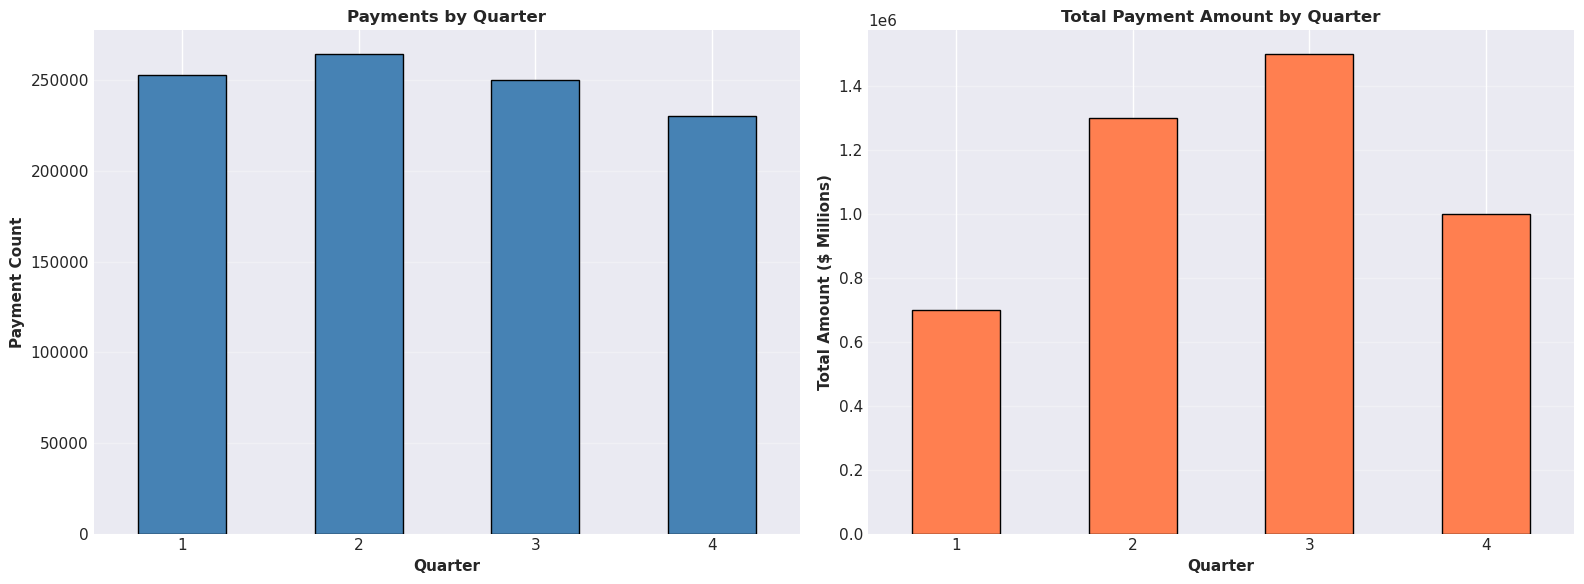

In [26]:
if 'payment_quarter' in df.columns and payment_col in df.columns:
    quarterly_stats = df.groupby('payment_quarter')[payment_col].agg(['count', 'sum', 'mean', 'median']).round(2)
    quarterly_stats.columns = ['Count', 'Total ($)', 'Mean ($)', 'Median ($)']
    quarterly_stats.index.name = 'Quarter'
    
    print("Quarterly Payment Statistics:")
    display(quarterly_stats)
    
    visualizer.plot_quarterly_trends(df, quarter_col='payment_quarter', amount_col=payment_col)
    plt.show()

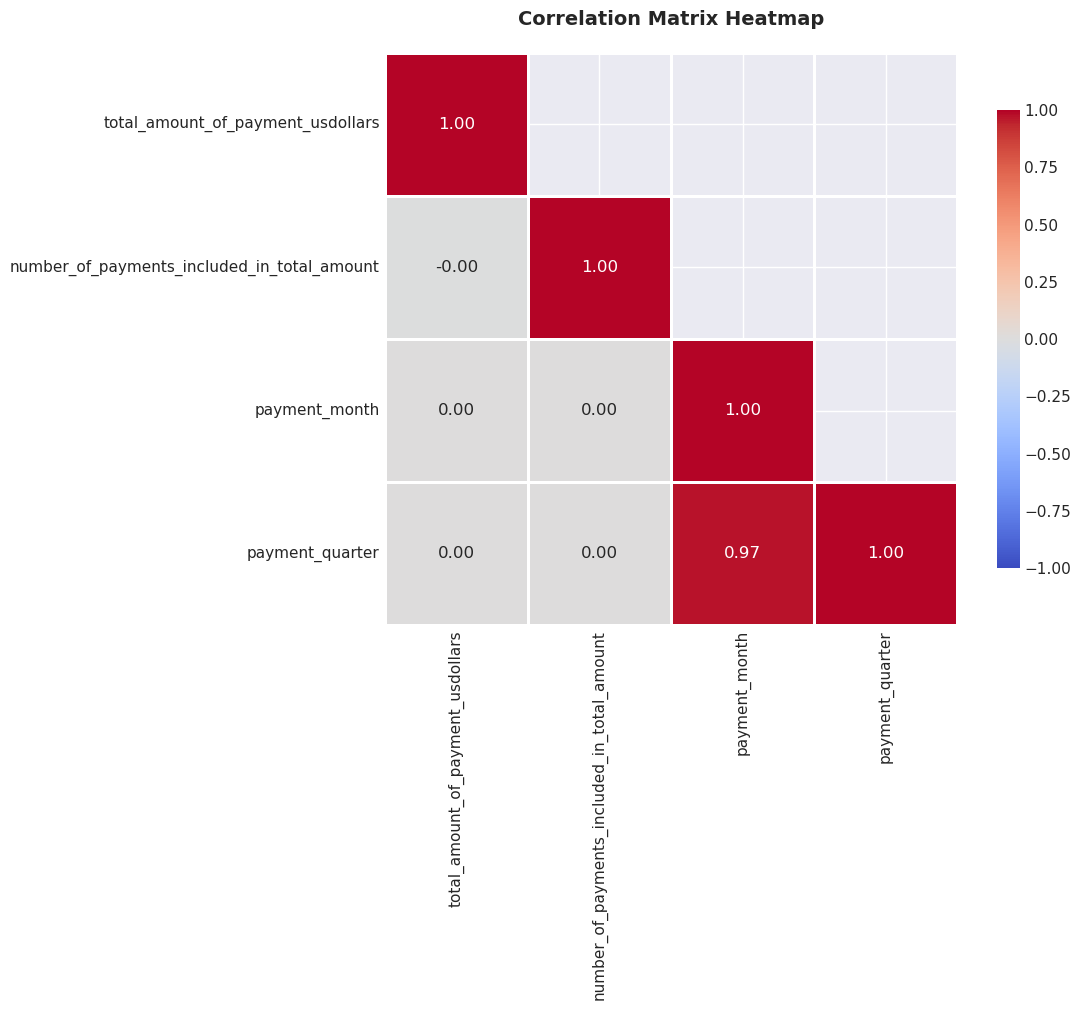

In [27]:
numeric_features_eda = [payment_col, 'number_of_payments_included_in_total_amount']
if 'payment_month' in df.columns:
    numeric_features_eda.append('payment_month')
if 'payment_quarter' in df.columns:
    numeric_features_eda.append('payment_quarter')

available_numeric = [col for col in numeric_features_eda if col in df.columns]

if len(available_numeric) >= 2:
    visualizer.plot_correlation_heatmap(df, available_numeric)
    plt.show()

## 6. Feature Engineering

In [28]:
np.random.seed(42)
perms = np.random.rand(len(df))

df['dataset_usage'] = pd.cut(
    perms, 
    bins=[0, 0.4, 0.5, 0.6, 1.0], 
    labels=['train', 'test', 'validation', 'production']
)

split_summary = df['dataset_usage'].value_counts().sort_index()
print("Data Split (40/10/10/40):")
for label in split_summary.index:
    pct = split_summary[label] / len(df) * 100
    print(f"  {label.capitalize()}: {split_summary[label]:,} ({pct:.1f}%)")

Data Split (40/10/10/40):
  Train: 398,604 (40.0%)
  Test: 99,600 (10.0%)
  Validation: 99,705 (10.0%)
  Production: 399,453 (40.1%)


In [29]:
target_id = 'covered_recipient_profile_id' 
payment_col = 'total_amount_of_payment_usdollars'

df_train = df[df['dataset_usage'] == 'train']
global_median = df_train[payment_col].median()

recipient_features = df_train.groupby(target_id).agg({
    payment_col: ['count', 'sum', 'mean', 'std', 'max']
}).reset_index()

recipient_features.columns = [
    target_id, 'hist_pay_count', 'hist_pay_total', 'hist_pay_avg', 'hist_pay_std', 'hist_pay_max'
]

df = df.merge(recipient_features, on=target_id, how='left')

df['amt_to_avg_ratio'] = df[payment_col] / df['hist_pay_avg']
df['amt_to_max_ratio'] = df[payment_col] / df['hist_pay_max']
df['is_new_recipient'] = df['hist_pay_avg'].isnull().astype(int)

df['hist_pay_avg'] = df['hist_pay_avg'].fillna(global_median)
df['amt_to_avg_ratio'] = df['amt_to_avg_ratio'].fillna(df[payment_col] / global_median)
df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']] = \
    df[['hist_pay_count', 'hist_pay_total', 'hist_pay_std', 'hist_pay_max', 'amt_to_max_ratio']].fillna(0)

print("Baseline features created")

Baseline features created


In [30]:
risk_categories = ['Gift', 'Entertainment', 'Travel and Lodging']
nature_col = 'nature_of_payment_or_transfer_of_value'

if nature_col in df.columns:
    df['is_high_risk_nature'] = df[nature_col].isin(risk_categories).astype(int)

print("Risk features created")

Risk features created


In [31]:
numeric_cols_df = df.select_dtypes(include=[np.number]).columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)

for col in numeric_cols_df:
    if col in df.columns:
        q999 = df[col].quantile(0.999)
        q001 = df[col].quantile(0.001)
        df[col] = df[col].clip(lower=q001, upper=q999)

print("Outliers capped")

Outliers capped


## 7. Isolation Forest Model Training

In [32]:
df_payments = df.copy()

numeric_cols = df_payments.select_dtypes(include=[np.number]).columns.tolist()

cols_to_exclude = [
    'EventTime', 'covered_recipient_profile_id', 'index',
    'teaching_hospital_id', 'covered_recipient_npi',
    'recipient_zip_code', 'recipient_province', 'recipient_postal_code'
]

numeric_features = [col for col in numeric_cols 
                   if col not in cols_to_exclude 
                   and not any(x in col.lower() for x in ['_id', '_code', '_province', '_postal'])]

X = df_payments[numeric_features].copy().astype(float)
X = X.replace([np.inf, -np.inf], np.nan)

missing_pct = (X.isnull().sum() / len(X)) * 100
cols_to_keep = missing_pct[missing_pct <= 50].index.tolist()
X = X[cols_to_keep]

for col in X.columns:
    q1, q3 = X[col].quantile(0.25), X[col].quantile(0.75)
    iqr = q3 - q1
    X[col] = X[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X = X.fillna(X.median())

print(f"Features prepared: {X.shape}")

Features prepared: (997362, 16)


In [33]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

print(f"Train: {len(X_train):,} | Test: {len(X_test):,}")

Train: 797,889 | Test: 199,473


In [34]:
baseline_params = {
    'n_estimators': 200,
    'contamination': 0.05,
    'max_samples': 'auto',
    'max_features': 1.0,
    'bootstrap': False,
    'random_state': 42
}

isolation_forest = IsolationForest(**baseline_params, n_jobs=-1, verbose=0)

print("Training Isolation Forest...")
start_time = time.time()
isolation_forest.fit(X_train)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f}s")

Training Isolation Forest...
Training completed in 10.57s


In [35]:
train_predictions = isolation_forest.predict(X_train)
train_scores = isolation_forest.decision_function(X_train)

test_predictions = isolation_forest.predict(X_test)
test_scores = isolation_forest.decision_function(X_test)

train_anomalies = (train_predictions == -1).astype(int)
test_anomalies = (test_predictions == -1).astype(int)

train_anomaly_count = train_anomalies.sum()
test_anomaly_count = test_anomalies.sum()

print(f"Train Anomalies: {train_anomaly_count:,} ({train_anomaly_count/len(X_train)*100:.2f}%)")
print(f"Test Anomalies: {test_anomaly_count:,} ({test_anomaly_count/len(X_test)*100:.2f}%)")

Train Anomalies: 39,895 (5.00%)
Test Anomalies: 9,916 (4.97%)


In [36]:
all_scores = isolation_forest.decision_function(X_scaled)
all_predictions = isolation_forest.predict(X_scaled)

anomaly_results = df_payments.copy()
anomaly_results['anomaly_score'] = all_scores
anomaly_results['is_anomaly'] = (all_predictions == -1).astype(int)
anomaly_results['anomaly_score_percentile'] = pd.Series(all_scores).rank(pct=True) * 100

anomalies_df = anomaly_results[anomaly_results['is_anomaly'] == 1].copy()
anomalies_df = anomalies_df.sort_values('anomaly_score', ascending=True)
normal_df = anomaly_results[anomaly_results['is_anomaly'] == 0]

print(f"Total Anomalies: {len(anomalies_df):,} ({len(anomalies_df)/len(anomaly_results)*100:.2f}%)")

top_anomalies = model_viz.display_top_anomalies(anomalies_df=anomalies_df, score_col='anomaly_score', top_n=10)
display(top_anomalies)

Total Anomalies: 49,811 (4.99%)

=== Top 10 Anomalous Payments (n=49,811) ===


,anomaly_score,anomaly_score_percentile,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
618504,-0.11,0.00,4400.00,Covered Recipient Physician,"""Compensation for services other than consulting",179.82,21.38,0,1,0
220806,-0.10,0.00,6400.00,Covered Recipient Physician,"""Compensation for services other than consulting",136.56,46.87,0,1,0
605763,-0.10,0.00,546.20,Covered Recipient Non-Physician Practitioner,Travel and Lodging,24.18,22.59,0,1,1
705124,-0.10,0.00,3600.00,Covered Recipient Physician,"""Compensation for services other than consulting",126.00,28.57,0,1,0
986862,-0.10,0.00,5250.00,Covered Recipient Physician,"""Compensation for services other than consulting",55.34,94.88,0,1,0
198768,-0.10,0.00,194.95,Covered Recipient Non-Physician Practitioner,Travel and Lodging,7.50,26.00,0,1,1
357304,-0.10,0.00,884.23,Covered Recipient Non-Physician Practitioner,Travel and Lodging,19.22,46.01,0,1,1
633900,-0.10,0.00,20.02,Covered Recipient Physician,1,0.64,31.10,0,1,0
56436,-0.10,0.00,1000.00,Covered Recipient Physician,"""Compensation for services other than consulting",33.36,29.97,0,1,0
449345,-0.09,0.00,681.20,Covered Recipient Physician,Travel and Lodging,24.58,27.72,0,1,1


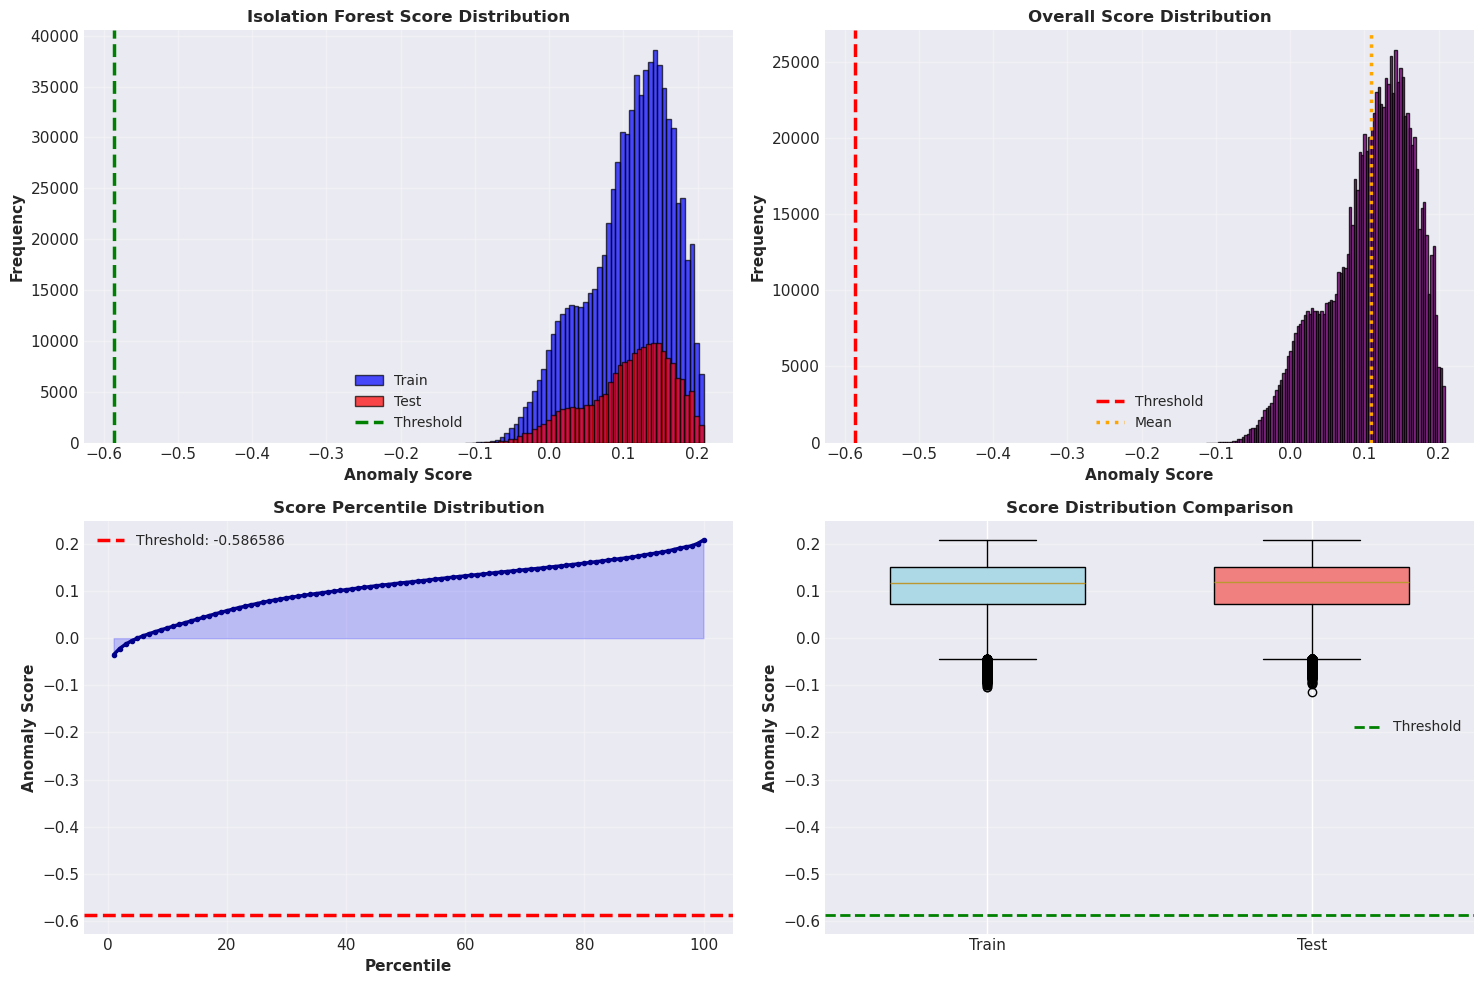

In [37]:
fig = model_viz.plot_anomaly_scores(
    train_scores=train_scores,
    test_scores=test_scores,
    threshold=isolation_forest.offset_,
    model_name='Isolation Forest'
)
plt.show()

### Anomaly Analysis by Payment Amount

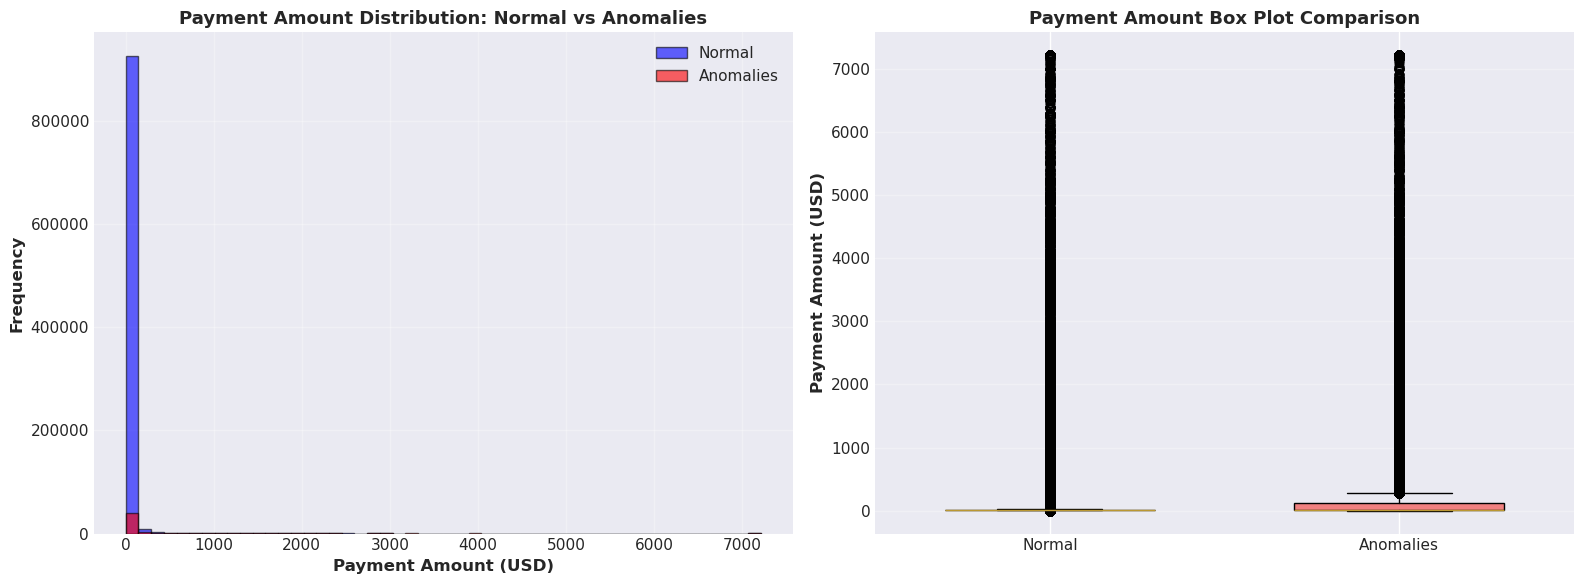

In [38]:
if 'total_amount_of_payment_usdollars' in anomaly_results.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df,
        anomaly_df=anomalies_df,
        amount_col='total_amount_of_payment_usdollars',
        score_col='anomaly_score'
    )
    plt.show()

### Training Performance Statistics

In [39]:
comparison_features = ['total_amount_of_payment_usdollars']
if 'amt_to_avg_ratio' in anomaly_results.columns:
    comparison_features.append('amt_to_avg_ratio')
if 'hist_pay_avg' in anomaly_results.columns:
    comparison_features.append('hist_pay_avg')

comparison_stats = model_viz.print_anomaly_stats(
    normal_df=normal_df,
    anomaly_df=anomalies_df,
    score_col='anomaly_score',
    comparison_features=comparison_features
)


=== Statistical Comparison ===
                                   Normal_Mean  Normal_Median  Anomaly_Mean  \
total_amount_of_payment_usdollars        46.64          20.02        407.30   
amt_to_avg_ratio                          1.52           1.00          4.45   
hist_pay_avg                             44.50          20.02        305.90   

                                   Anomaly_Median  Difference_%  
total_amount_of_payment_usdollars           20.02        773.32  
amt_to_avg_ratio                             0.54        193.34  
hist_pay_avg                                73.33        587.40  

=== Anomaly Score Statistics ===
   Metric  Normal  Anomaly
0    Mean    0.12    -0.02
1  Median    0.12    -0.02
2     Min    0.00    -0.11
3     Max    0.21    -0.00


In [40]:
train_anomaly_pct = (train_anomaly_count / len(X_train)) * 100
test_anomaly_pct = (test_anomaly_count / len(X_test)) * 100

print(f"Training Set: {train_anomaly_count:,} anomalies ({train_anomaly_pct:.2f}%)")
print(f"Test Set: {test_anomaly_count:,} anomalies ({test_anomaly_pct:.2f}%)")
print(f"Decision Threshold: {isolation_forest.offset_:.6f}")
print(f"Score Range: [{all_scores.min():.6f}, {all_scores.max():.6f}]")

Training Set: 39,895 anomalies (5.00%)
Test Set: 9,916 anomalies (4.97%)
Decision Threshold: -0.586586
Score Range: [-0.113341, 0.207949]


## 8. Autoencoder Model Training

In [41]:
X_ae = df_payments[numeric_features].copy().astype(float)
X_ae = X_ae.replace([np.inf, -np.inf], np.nan)

missing_pct_ae = (X_ae.isnull().sum() / len(X_ae)) * 100
cols_to_keep_ae = missing_pct_ae[missing_pct_ae <= 50].index.tolist()
X_ae = X_ae[cols_to_keep_ae]

for col in X_ae.columns:
    q1, q3 = X_ae[col].quantile(0.25), X_ae[col].quantile(0.75)
    iqr = q3 - q1
    X_ae[col] = X_ae[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X_ae = X_ae.fillna(X_ae.median())

scaler_ae = MinMaxScaler(feature_range=(0, 1))
X_ae_scaled = scaler_ae.fit_transform(X_ae)
X_ae_scaled = pd.DataFrame(X_ae_scaled, columns=X_ae.columns)

X_ae_train, X_ae_test = train_test_split(X_ae_scaled, test_size=0.2, random_state=42)

print(f"Data prepared: {X_ae_scaled.shape} | Train: {len(X_ae_train):,} | Test: {len(X_ae_test):,}")

Data prepared: (997362, 16) | Train: 797,889 | Test: 199,473


In [42]:
input_dim = X_ae_scaled.shape[1]
encoding_dim_1 = max(input_dim // 2, 32)
encoding_dim_2 = max(input_dim // 4, 16)
bottleneck_dim = max(input_dim // 8, 8)

autoencoder = Sequential([
    layers.Dense(encoding_dim_1, activation='relu', input_shape=(input_dim,), name='encoder_input'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim_2, activation='relu', name='encoder_middle'),
    layers.Dropout(0.2),
    layers.Dense(bottleneck_dim, activation='relu', name='bottleneck'),
    layers.Dense(encoding_dim_2, activation='relu', name='decoder_middle'),
    layers.Dropout(0.2),
    layers.Dense(encoding_dim_1, activation='relu', name='decoder_layer'),
    layers.Dropout(0.2),
    layers.Dense(input_dim, activation='sigmoid', name='decoder_output')
], name='Autoencoder')

optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print(f"Architecture: {input_dim} -> {encoding_dim_1} -> {encoding_dim_2} -> {bottleneck_dim} (bottleneck)")

Architecture: 16 -> 32 -> 16 -> 8 (bottleneck)


In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=0,
    min_delta=1e-5
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

start_time = time.time()

history_ae = autoencoder.fit(
    X_ae_train, X_ae_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)

training_time_ae = time.time() - start_time
print(f"Training: {len(history_ae.history['loss'])} epochs in {training_time_ae:.2f}s")

Training: 31 epochs in 887.04s


In [44]:
train_predictions_ae = autoencoder.predict(X_ae_train, verbose=0)
train_mse_ae = np.mean(np.square(X_ae_train - train_predictions_ae), axis=1)

test_predictions_ae = autoencoder.predict(X_ae_test, verbose=0)
test_mse_ae = np.mean(np.square(X_ae_test - test_predictions_ae), axis=1)

all_data_ae = np.vstack([X_ae_train, X_ae_test])
all_predictions_ae = autoencoder.predict(all_data_ae, verbose=0)
all_reconstruction_errors = np.mean(np.square(all_data_ae - all_predictions_ae), axis=1)

threshold_ae = np.percentile(train_mse_ae, 95)
anomaly_labels_ae = (all_reconstruction_errors > threshold_ae).astype(int)
anomaly_count_ae = anomaly_labels_ae.sum()

print(f"Threshold: {threshold_ae:.6f} | Anomalies: {anomaly_count_ae:,} ({anomaly_count_ae/len(anomaly_labels_ae)*100:.2f}%)")

Threshold: 0.027161 | Anomalies: 49,828 (5.00%)


In [45]:
all_predictions_ae_full = autoencoder.predict(X_ae_scaled, verbose=0)
all_reconstruction_errors_full = np.mean(np.square(X_ae_scaled - all_predictions_ae_full), axis=1)
anomaly_labels_ae_full = (all_reconstruction_errors_full > threshold_ae).astype(int)

anomaly_results_ae = df_payments.copy()
anomaly_results_ae['reconstruction_error'] = all_reconstruction_errors_full
anomaly_results_ae['is_anomaly'] = anomaly_labels_ae_full

anomalies_df_ae = anomaly_results_ae[anomaly_results_ae['is_anomaly'] == 1].copy()
anomalies_df_ae = anomalies_df_ae.sort_values('reconstruction_error', ascending=False)
normal_df_ae = anomaly_results_ae[anomaly_results_ae['is_anomaly'] == 0]

top_anomalies_ae = model_viz.display_top_anomalies(
    anomalies_df=anomalies_df_ae,
    score_col='reconstruction_error',
    top_n=10
)
display(top_anomalies_ae)


=== Top 10 Anomalous Payments (n=49,828) ===


,reconstruction_error,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
230379,0.13,20.02,Covered Recipient Physician,1,4.65,4.31,0,0,0
284888,0.13,20.02,Covered Recipient Physician,1,6.38,3.14,0,0,0
917729,0.13,20.02,Covered Recipient Physician,1,21.30,1.70,0,0,0
327833,0.12,20.02,Covered Recipient Physician,1,3.84,5.22,0,0,0
286285,0.12,20.02,Covered Recipient Physician,1,4.74,4.22,0,1,0
748068,0.12,20.02,Covered Recipient Physician,1,4.63,4.32,0,0,0
472942,0.12,20.02,Covered Recipient Physician,1,4.00,5.00,0,1,0
95392,0.12,20.02,Covered Recipient Non-Physician Practitioner,1,4.01,4.99,0,0,0
885186,0.12,20.02,Covered Recipient Physician,1,8.38,2.39,0,0,0
611462,0.12,20.02,Covered Recipient Physician,1,4.55,4.40,0,0,0


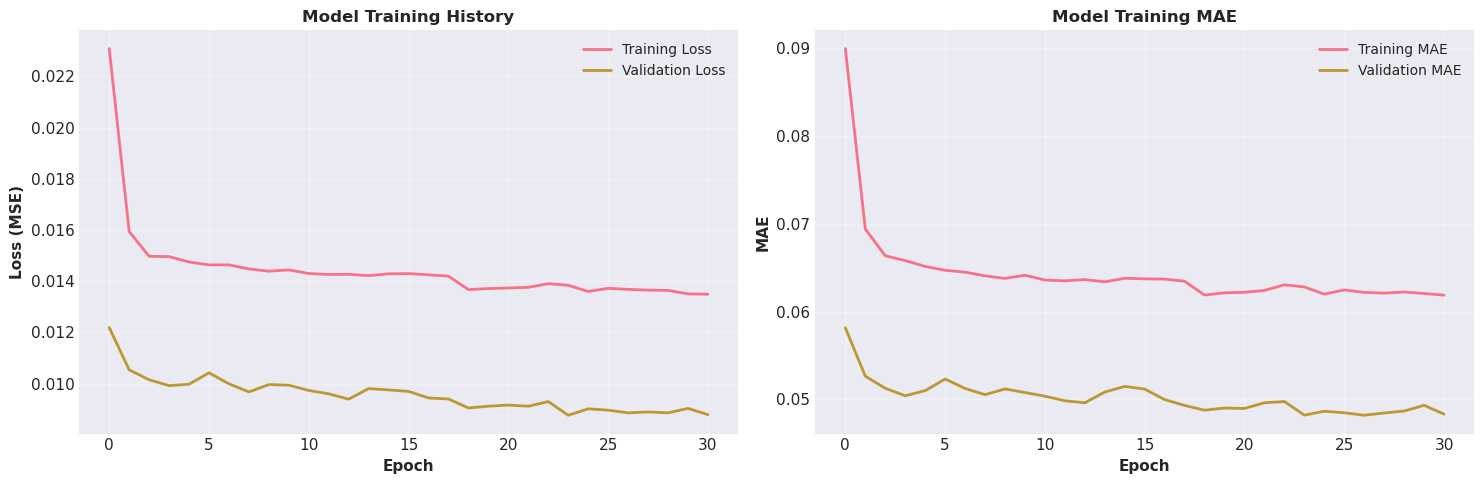

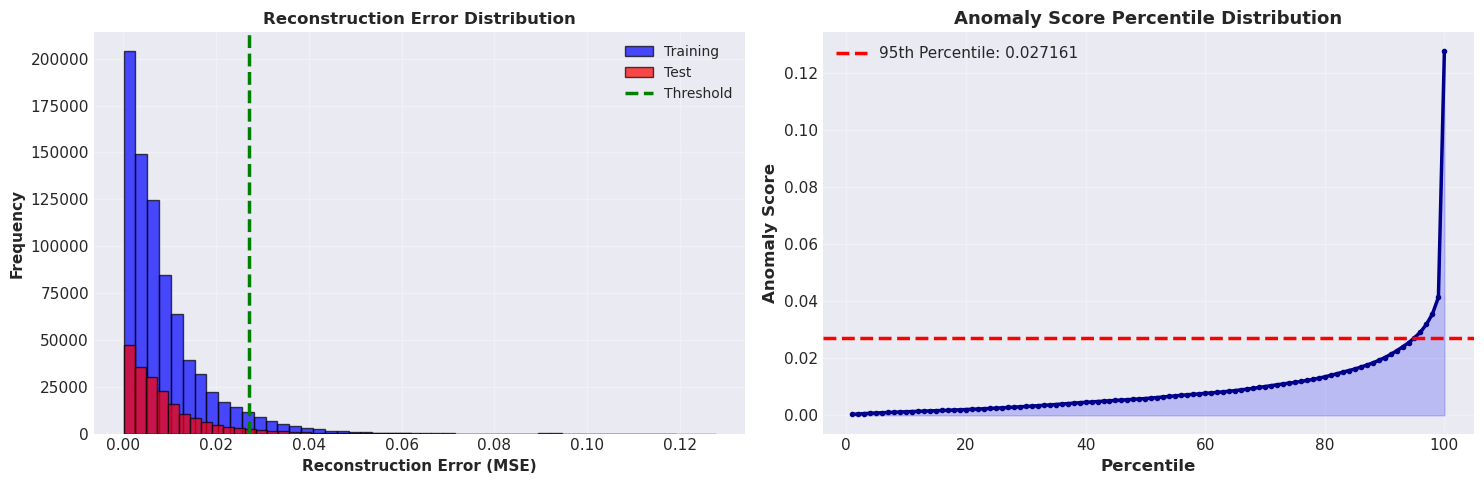

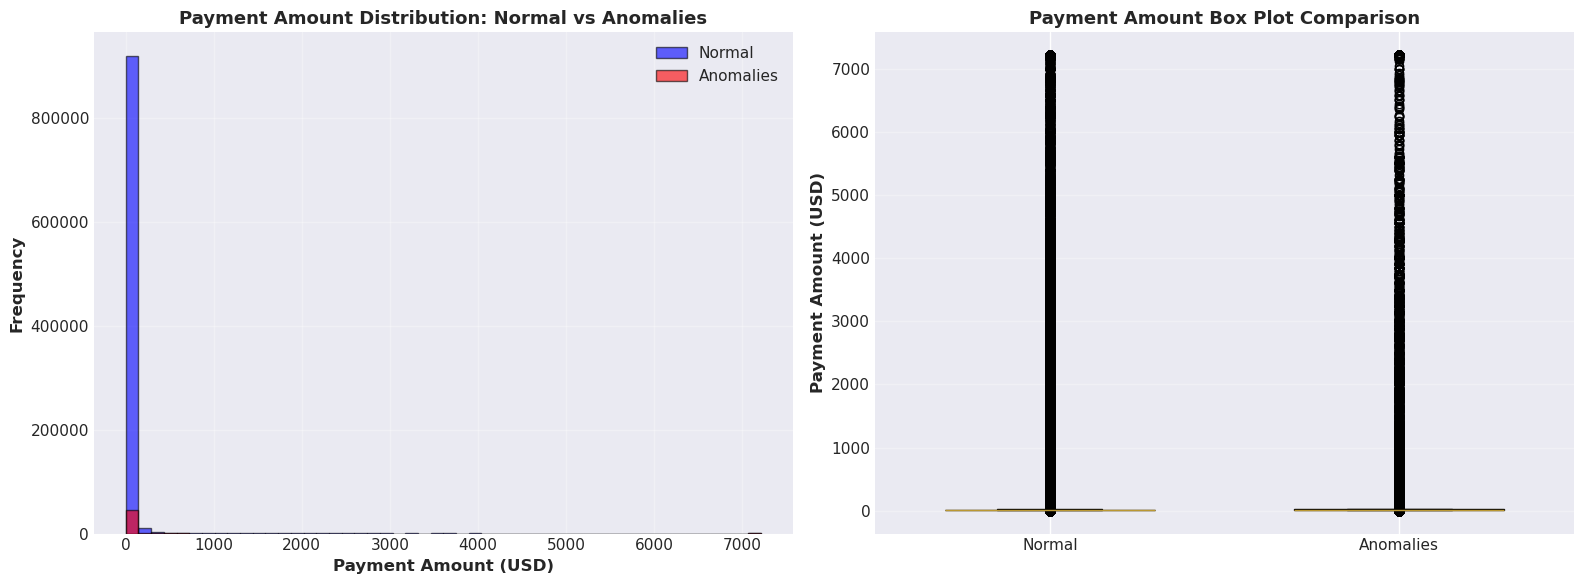

In [46]:
fig = model_viz.plot_training_history(history=history_ae.history, figsize=(15, 5))
plt.show()

fig = model_viz.plot_reconstruction_error_analysis(
    train_mse=train_mse_ae,
    test_mse=test_mse_ae,
    threshold=threshold_ae,
    all_reconstruction_errors=all_reconstruction_errors,
    figsize=(15, 5)
)
plt.show()

if 'total_amount_of_payment_usdollars' in anomaly_results_ae.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df_ae,
        anomaly_df=anomalies_df_ae,
        amount_col='total_amount_of_payment_usdollars',
        score_col='reconstruction_error'
    )
    plt.show()

## 9. XGBoost Model Training

In [47]:
X_xgb = df_payments[numeric_features].copy().astype(float)
X_xgb = X_xgb.replace([np.inf, -np.inf], np.nan)

missing_pct_xgb = (X_xgb.isnull().sum() / len(X_xgb)) * 100
cols_to_keep_xgb = missing_pct_xgb[missing_pct_xgb <= 50].index.tolist()
X_xgb = X_xgb[cols_to_keep_xgb]

for col in X_xgb.columns:
    q1, q3 = X_xgb[col].quantile(0.25), X_xgb[col].quantile(0.75)
    iqr = q3 - q1
    X_xgb[col] = X_xgb[col].clip(lower=q1 - 3*iqr, upper=q3 + 3*iqr)

X_xgb = X_xgb.fillna(X_xgb.median())

outlier_indicators = []
for col in X_xgb.columns:
    z_scores = np.abs((X_xgb[col] - X_xgb[col].mean()) / X_xgb[col].std())
    outlier_indicators.append((z_scores > 3).astype(int))

outlier_score = pd.DataFrame(outlier_indicators).T.sum(axis=1)
threshold_value = np.percentile(outlier_score, 95)
y_pseudo = (outlier_score >= threshold_value).astype(int)

print(f"Pseudo-labels: {y_pseudo.sum():,} anomalies ({y_pseudo.sum()/len(y_pseudo)*100:.2f}%)")

Pseudo-labels: 84,801 anomalies (8.50%)


In [48]:
scaler_xgb = RobustScaler()
X_xgb_scaled = scaler_xgb.fit_transform(X_xgb)
X_xgb_scaled = pd.DataFrame(X_xgb_scaled, columns=X_xgb.columns)

X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(
    X_xgb_scaled, y_pseudo, 
    test_size=0.2, 
    random_state=42,
    stratify=y_pseudo
)

print(f"Train: {len(X_xgb_train):,} ({y_xgb_train.sum()} anomalies) | Test: {len(X_xgb_test):,} ({y_xgb_test.sum()} anomalies)")

Train: 797,889 (67841 anomalies) | Test: 199,473 (16960 anomalies)


In [49]:
scale_pos_weight = (y_xgb_train == 0).sum() / (y_xgb_train == 1).sum()

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

xgb_model = xgb.XGBClassifier(**xgb_params)

start_time = time.time()
xgb_model.fit(
    X_xgb_train, y_xgb_train,
    eval_set=[(X_xgb_train, y_xgb_train), (X_xgb_test, y_xgb_test)],
    verbose=False
)
training_time_xgb = time.time() - start_time

print(f"Training: {training_time_xgb:.2f}s")

Training: 25.19s


AUC: Train=0.999998 | Test=0.999992


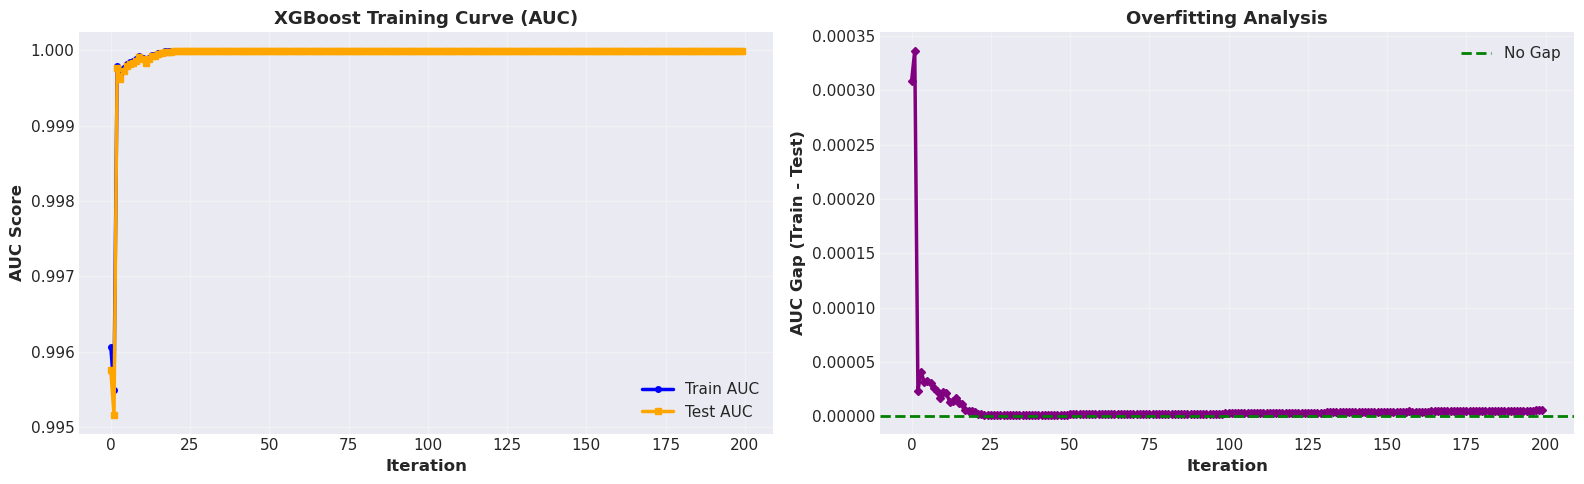

In [50]:
train_pred_xgb = xgb_model.predict(X_xgb_train)
train_proba_xgb = xgb_model.predict_proba(X_xgb_train)[:, 1]

test_pred_xgb = xgb_model.predict(X_xgb_test)
test_proba_xgb = xgb_model.predict_proba(X_xgb_test)[:, 1]

train_auc = roc_auc_score(y_xgb_train, train_proba_xgb)
test_auc = roc_auc_score(y_xgb_test, test_proba_xgb)

print(f"AUC: Train={train_auc:.6f} | Test={test_auc:.6f}")

results_xgb = xgb_model.evals_result()
best_iter = None
try:
    best_iter = xgb_model.best_iteration
except AttributeError:
    pass

fig = model_viz.plot_xgboost_training_curves(results=results_xgb, best_iteration=best_iter)
plt.show()

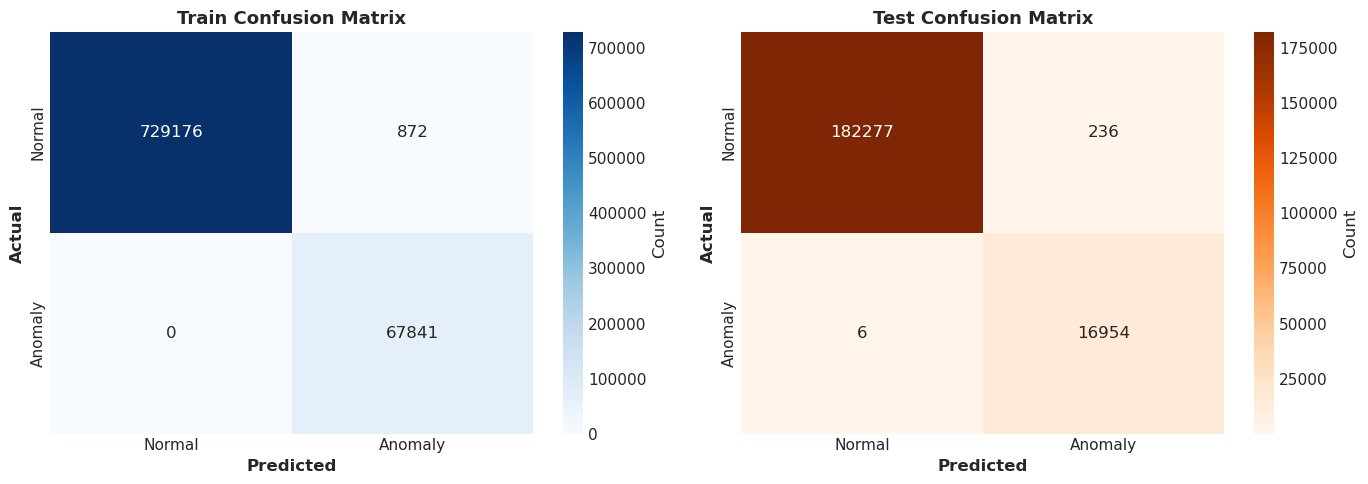

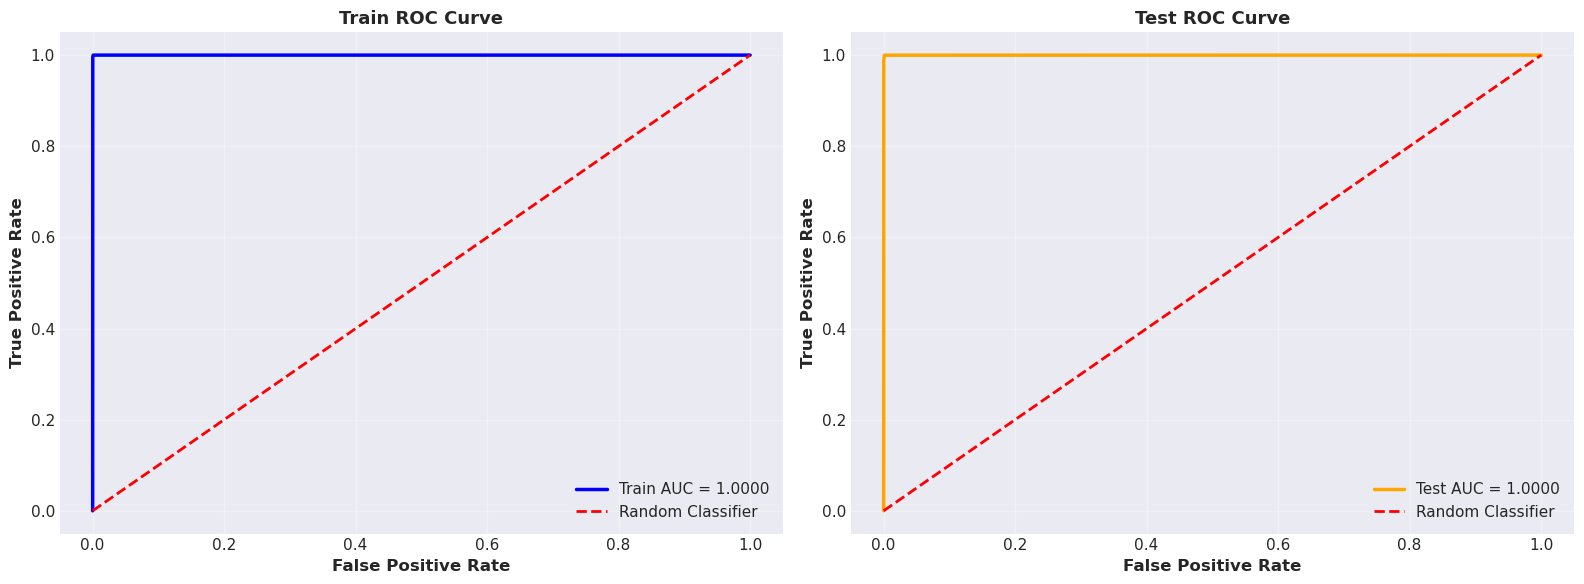

In [51]:
fig = model_viz.plot_confusion_matrices(
    y_train=y_xgb_train,
    train_pred=train_pred_xgb,
    y_test=y_xgb_test,
    test_pred=test_pred_xgb
)
plt.show()

fig = model_viz.plot_roc_curves(
    y_train=y_xgb_train,
    train_proba=train_proba_xgb,
    y_test=y_xgb_test,
    test_proba=test_proba_xgb,
    train_auc=train_auc,
    test_auc=test_auc
)
plt.show()

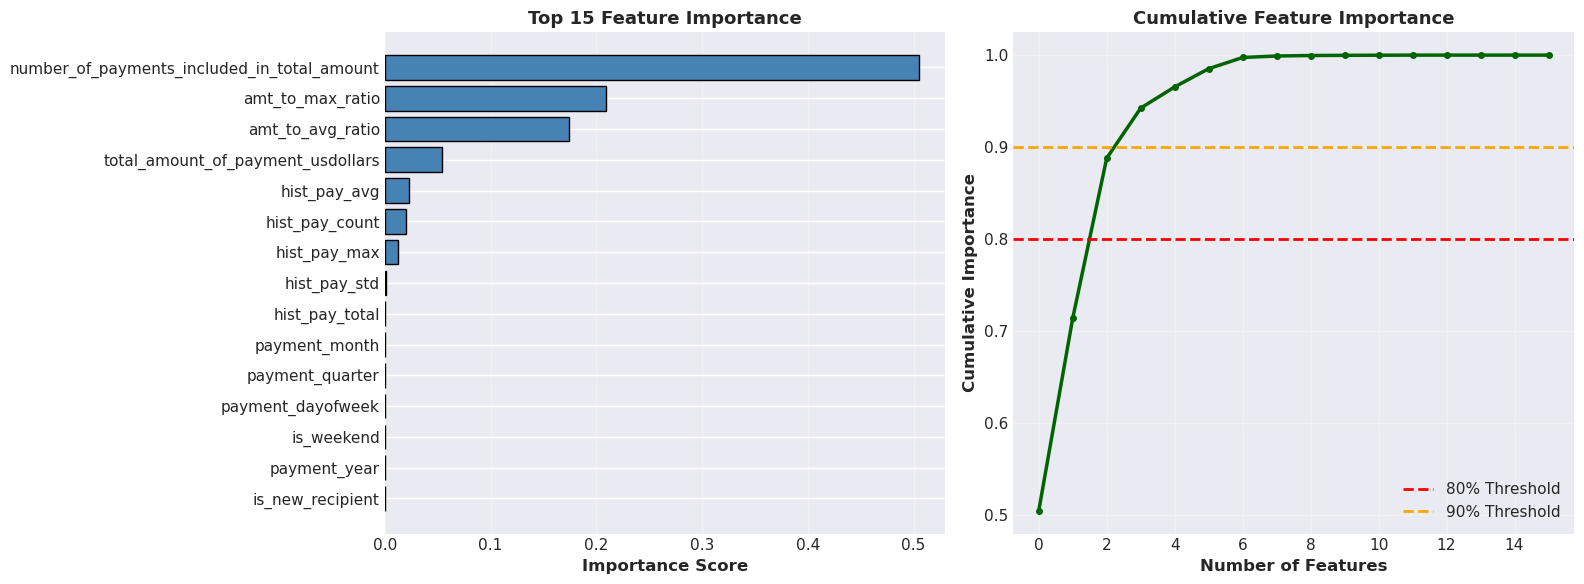

Top 10 Important Features:


,feature,importance
1,number_of_payments_included_in_total_amount,0.50
13,amt_to_max_ratio,0.21
12,amt_to_avg_ratio,0.17
0,total_amount_of_payment_usdollars,0.05
9,hist_pay_avg,0.02
7,hist_pay_count,0.02
11,hist_pay_max,0.01
10,hist_pay_std,0.00
8,hist_pay_total,0.00
3,payment_month,0.00


In [52]:
fig, feature_importance = model_viz.plot_feature_importance(
    feature_names=X_xgb.columns,
    feature_importances=xgb_model.feature_importances_,
    top_n=15
)
plt.show()

print("Top 10 Important Features:")
display(feature_importance.head(10))

Anomalies: 85,903 (8.61%)

=== Top 10 Anomalous Payments (n=85,903) ===


,anomaly_score,total_amount_of_payment_usdollars,covered_recipient_type,nature_of_payment_or_transfer_of_value,amt_to_avg_ratio,hist_pay_avg,is_new_recipient,is_weekend,is_high_risk_nature
446601,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,3.07,6.53,0,0,0
878898,1.00,20.02,Covered Recipient Physician,1,3.57,5.61,0,0,0
731892,1.00,20.02,Covered Recipient Physician,1,4.89,4.09,0,0,0
708064,1.00,20.02,Covered Recipient Physician,1,3.48,5.76,0,0,0
428275,1.00,20.02,Covered Recipient Physician,1,3.13,6.39,0,0,0
301677,1.00,20.02,Covered Recipient Physician,1,8.24,2.43,0,0,0
256138,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,3.78,5.29,0,0,0
418836,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,3.51,5.70,0,0,0
621669,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,6.22,3.22,0,0,0
717851,1.00,20.02,Covered Recipient Non-Physician Practitioner,1,2.97,6.75,0,0,0


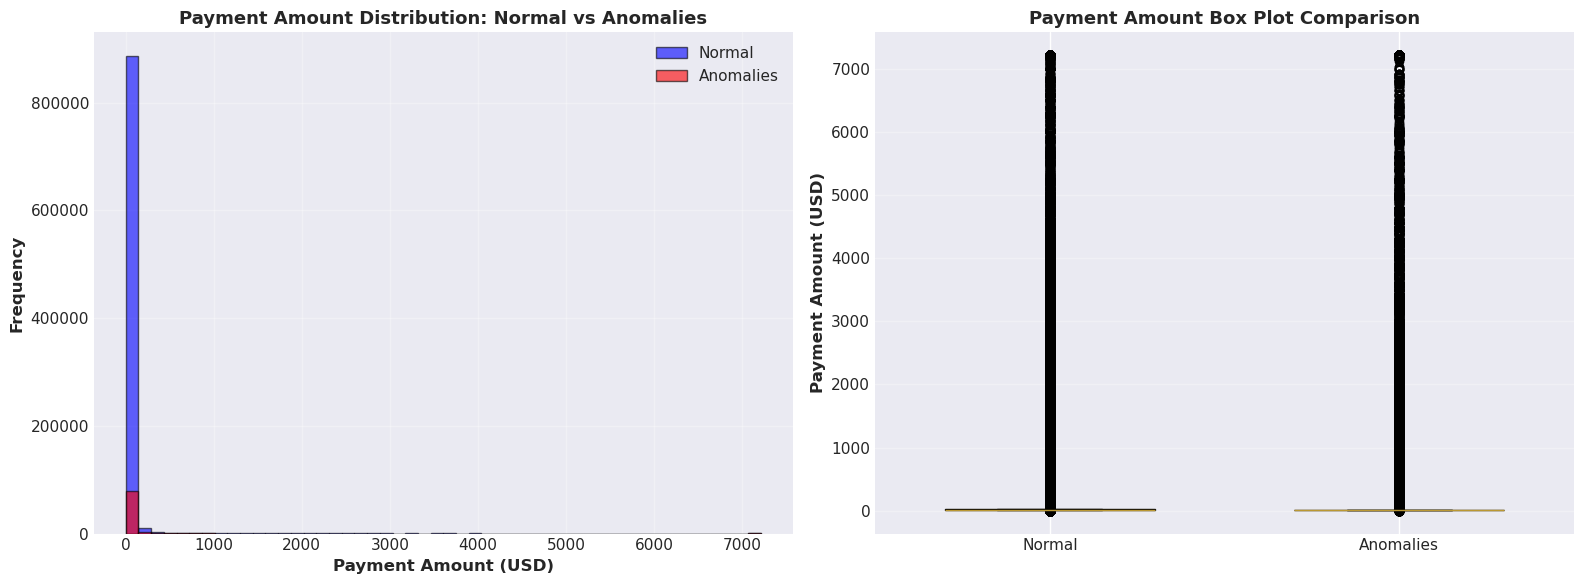

In [53]:
all_proba_xgb_full = xgb_model.predict_proba(X_xgb_scaled)[:, 1]

threshold_xgb = 0.5
anomaly_labels_xgb_full = (all_proba_xgb_full >= threshold_xgb).astype(int)

anomaly_results_xgb = df_payments.copy()
anomaly_results_xgb['anomaly_score'] = all_proba_xgb_full
anomaly_results_xgb['is_anomaly'] = anomaly_labels_xgb_full

anomalies_df_xgb = anomaly_results_xgb[anomaly_results_xgb['is_anomaly'] == 1].copy()
anomalies_df_xgb = anomalies_df_xgb.sort_values('anomaly_score', ascending=False)
normal_df_xgb = anomaly_results_xgb[anomaly_results_xgb['is_anomaly'] == 0]

print(f"Anomalies: {len(anomalies_df_xgb):,} ({len(anomalies_df_xgb)/len(anomaly_results_xgb)*100:.2f}%)")

top_anomalies_xgb = model_viz.display_top_anomalies(
    anomalies_df=anomalies_df_xgb,
    score_col='anomaly_score',
    top_n=10
)
display(top_anomalies_xgb)

if 'total_amount_of_payment_usdollars' in anomaly_results_xgb.columns:
    fig = model_viz.plot_anomaly_comparison(
        normal_df=normal_df_xgb,
        anomaly_df=anomalies_df_xgb,
        amount_col='total_amount_of_payment_usdollars',
        score_col='anomaly_score'
    )
    plt.show()

## 10. Hyperparameter Tuning

In [54]:
def anomaly_score_separation(estimator, X):
    try:
        scores = estimator.decision_function(X)
        predictions = estimator.predict(X)
        
        if np.any(~np.isfinite(scores)):
            return 0.0
        
        anomaly_scores = scores[predictions == -1]
        normal_scores = scores[predictions == 1]
        
        if len(anomaly_scores) < 3 or len(normal_scores) < 3:
            return 0.0
        
        mean_diff = normal_scores.mean() - anomaly_scores.mean()
        pooled_std = np.sqrt((normal_scores.std()**2 + anomaly_scores.std()**2) / 2)
        
        if pooled_std < 1e-6:
            return 0.0
        
        separation = mean_diff / pooled_std
        
        if not np.isfinite(separation):
            return 0.0
            
        return float(separation)
        
    except Exception:
        return 0.0

anomaly_scorer = make_scorer(anomaly_score_separation, greater_is_better=True)

In [55]:
grid_param_grid = {
    'n_estimators': [150, 250],
    'contamination': [0.03, 0.05, 0.07],
    'max_samples': [512],
    'max_features': [0.8, 1.0],
    'bootstrap': [False, True]
}

print(f"Starting Grid Search...")

grid_search = GridSearchCV(
    estimator=IsolationForest(random_state=42, n_jobs=-1, verbose=0),
    param_grid=grid_param_grid,
    scoring=anomaly_scorer,
    cv=2,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train)
print(f"Grid Search complete | Best Score: {grid_search.best_score_:.6f}")

Starting Grid Search...
Fitting 2 folds for each of 24 candidates, totalling 48 fits


Grid Search complete | Best Score: nan


In [56]:
random_param_dist = {
    'n_estimators': randint(50, 500),
    'contamination': uniform(0.01, 0.15),
    'max_samples': [512, 1024, 2048],
    'max_features': uniform(0.5, 0.5),
    'bootstrap': [False, True]
}

print(f"Starting Randomized Search...")

random_search = RandomizedSearchCV(
    estimator=IsolationForest(random_state=42, n_jobs=-1, verbose=0),
    param_distributions=random_param_dist,
    n_iter=30,
    scoring=anomaly_scorer,
    cv=2,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

random_search.fit(X_train)
print(f"Randomized Search complete | Best Score: {random_search.best_score_:.6f}")

Starting Randomized Search...
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Randomized Search complete | Best Score: nan


### Hyperparameter Search Results

In [57]:
grid_results_df = pd.DataFrame(grid_search.cv_results_)
random_results_df = pd.DataFrame(random_search.cv_results_)

fig = model_viz.plot_grid_search_results(grid_results_df)
plt.show()

In [58]:
fig = model_viz.plot_random_search_results(random_results_df, random_search.best_score_)
plt.show()

In [59]:
if grid_search.best_score_ > random_search.best_score_:
    best_search = grid_search
    best_method = 'Grid Search'
else:
    best_search = random_search
    best_method = 'Randomized Search'

optimal_params = best_search.best_params_.copy()
optimal_params['random_state'] = 42
optimal_params['n_jobs'] = -1
optimal_params['verbose'] = 0

print(f"Best Method: {best_method}")
print(f"Optimal Parameters: {optimal_params}")

Best Method: Randomized Search
Optimal Parameters: {'bootstrap': False, 'contamination': 0.1294814480290349, 'max_features': 0.5917173949330818, 'max_samples': 512, 'n_estimators': 70, 'random_state': 42, 'n_jobs': -1, 'verbose': 0}


In [60]:
print("Training optimized model...")

optimized_model = IsolationForest(**optimal_params)
optimized_model.fit(X_train)

optimized_test_predictions = optimized_model.predict(X_test)
optimized_test_anomalies = (optimized_test_predictions == -1).sum()

print(f"Optimized Model - Test Anomalies: {optimized_test_anomalies:,} ({optimized_test_anomalies/len(X_test)*100:.2f}%)")

Training optimized model...
Optimized Model - Test Anomalies: 25,634 (12.85%)


### Baseline vs Optimized Model Comparison

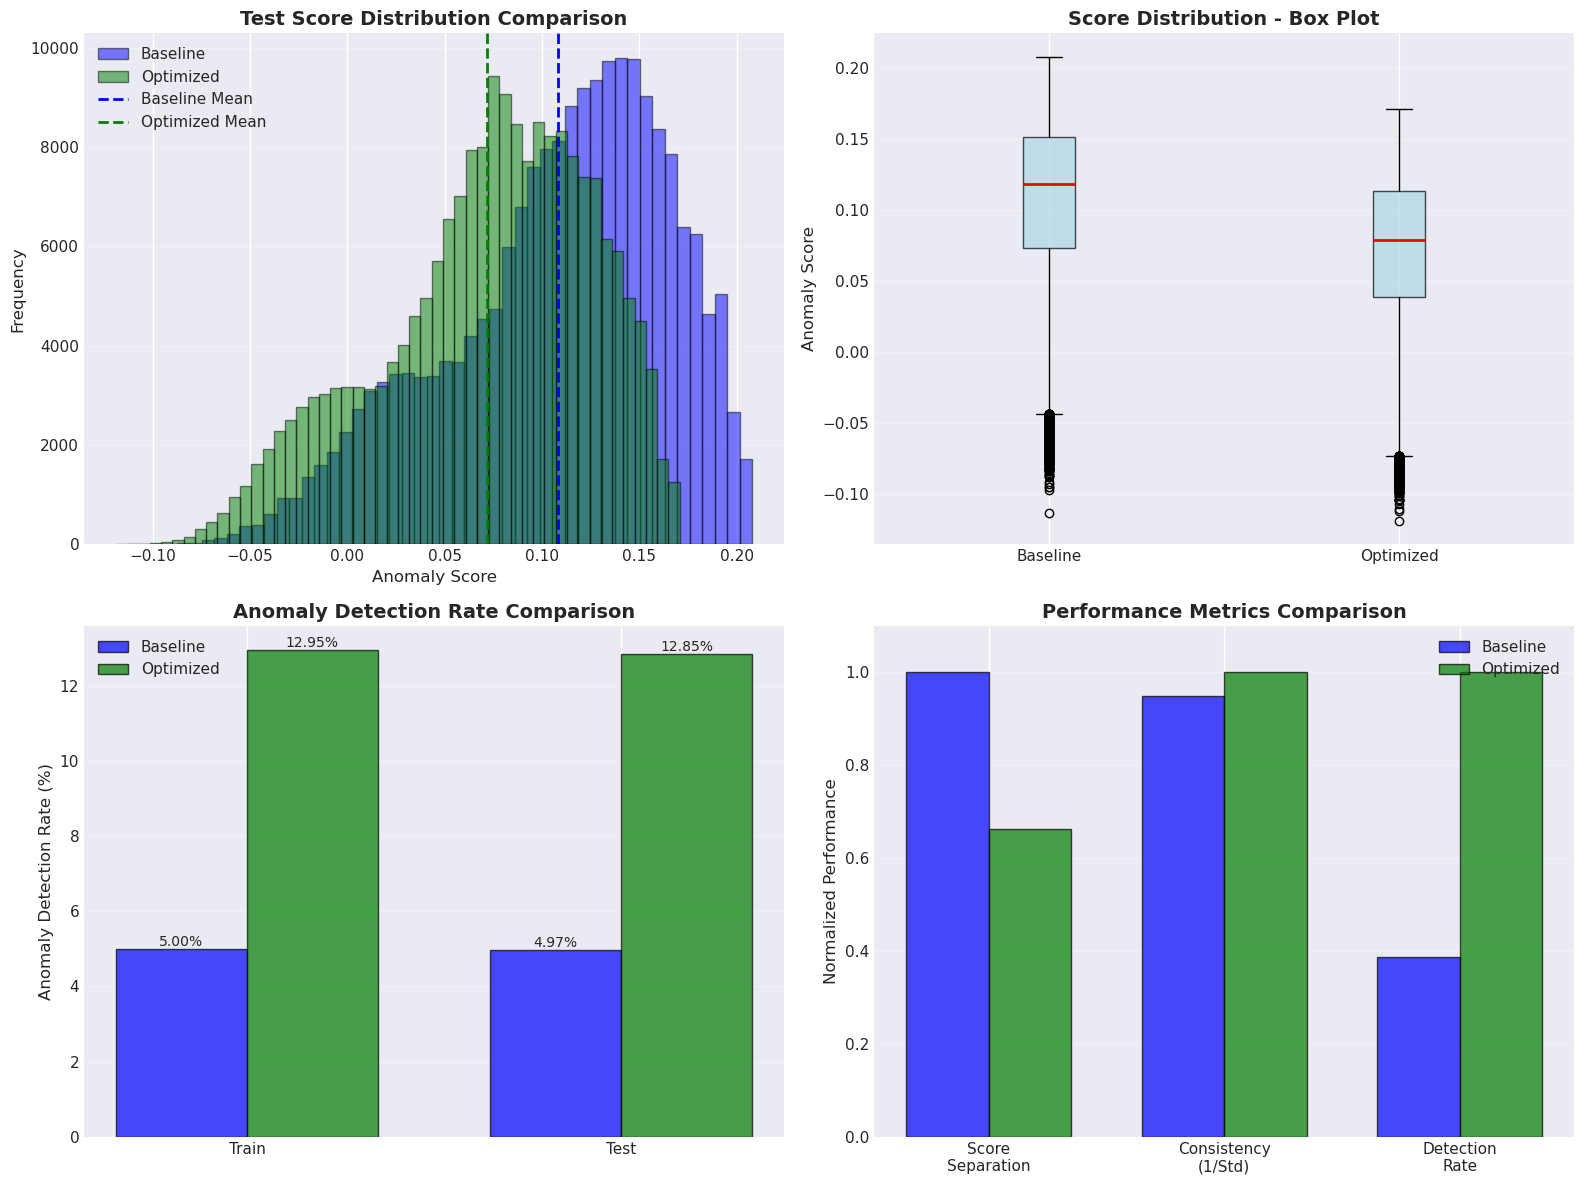

In [61]:
baseline_test_scores = test_scores
optimized_test_scores = optimized_model.decision_function(X_test)
optimized_train_predictions = optimized_model.predict(X_train)
optimized_train_anomalies = (optimized_train_predictions == -1).sum()

baseline_score_mean = baseline_test_scores.mean()
baseline_score_std = baseline_test_scores.std()
optimized_score_mean = optimized_test_scores.mean()
optimized_score_std = optimized_test_scores.std()

fig = model_viz.plot_model_comparison(
    baseline_test_scores,
    optimized_test_scores,
    train_anomaly_count,
    test_anomaly_count,
    optimized_train_anomalies,
    optimized_test_anomalies,
    len(X_train),
    len(X_test),
    baseline_score_mean,
    optimized_score_mean,
    baseline_score_std,
    optimized_score_std
)
plt.show()

### Hyperparameter Tuning Summary

In [62]:
tuning_summary = pd.DataFrame({
    'Method': ['Baseline', 'Grid Search', 'Randomized Search'],
    'Best Score': ['N/A', f"{grid_search.best_score_:.6f}", f"{random_search.best_score_:.6f}"],
    'N Estimators': [
        baseline_params['n_estimators'],
        grid_search.best_params_['n_estimators'],
        random_search.best_params_['n_estimators']
    ],
    'Contamination': [
        baseline_params['contamination'],
        grid_search.best_params_['contamination'],
        random_search.best_params_['contamination']
    ],
    'Test Anomalies': [
        f"{test_anomaly_count:,} ({test_anomaly_count/len(X_test)*100:.2f}%)",
        'N/A',
        f"{optimized_test_anomalies:,} ({optimized_test_anomalies/len(X_test)*100:.2f}%)"
    ]
})

print("Hyperparameter Tuning Comparison:")
display(tuning_summary)

Hyperparameter Tuning Comparison:


,Method,Best Score,N Estimators,Contamination,Test Anomalies
0,Baseline,N/A,200,0.05,"9,916 (4.97%)"
1,Grid Search,nan,150,0.03,N/A
2,Randomized Search,nan,70,0.13,"25,634 (12.85%)"


## 11. Model Deployment to SageMaker

In [63]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
sagemaker_region = sagemaker_session.boto_region_name
sagemaker_bucket = sagemaker_session.default_bucket()
s3_prefix = 'cms-anomaly-detection'

sagemaker_client = boto3.client('sagemaker')

print(f"SageMaker Region: {sagemaker_region} | Bucket: {sagemaker_bucket}")

SageMaker Region: us-east-1 | Bucket: sagemaker-us-east-1-864106638709


In [64]:
model_card = {
    "model_details": {
        "name": "CMS Open Payments Anomaly Detector",
        "version": "1.0",
        "type": "Isolation Forest",
        "framework": "scikit-learn",
        "created_date": datetime.now().strftime('%Y-%m-%d'),
        "created_by": "AAI-540 Team"
    },
    "model_parameters": {
        "contamination": optimal_params.get('contamination', 0.05),
        "n_estimators": optimal_params.get('n_estimators', 200),
        "max_samples": optimal_params.get('max_samples', 'auto'),
        "max_features": optimal_params.get('max_features', 1.0)
    }
}

with open('model_card.json', 'w') as f:
    json.dump(model_card, f, indent=2)

print("Model card created")

Model card created


In [65]:
inference_script = '''import os
import json
import joblib
import numpy as np
import pandas as pd

def model_fn(model_dir):
    model_path = os.path.join(model_dir, 'model.joblib')
    scaler_path = os.path.join(model_dir, 'scaler.joblib')
    
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    return {'model': model, 'scaler': scaler}

def input_fn(request_body, request_content_type):
    if request_content_type == 'application/json':
        data = json.loads(request_body)
        return pd.DataFrame(data)
    else:
        raise ValueError(f'Unsupported content type: {request_content_type}')

def predict_fn(input_data, model_artifacts):
    model = model_artifacts['model']
    scaler = model_artifacts['scaler']
    
    scaled_data = scaler.transform(input_data)
    predictions = model.predict(scaled_data)
    scores = model.decision_function(scaled_data)
    
    anomaly_labels = (predictions == -1).astype(int).tolist()
    
    return {
        'predictions': anomaly_labels,
        'anomaly_scores': scores.tolist()
    }

def output_fn(prediction, response_content_type):
    if response_content_type == 'application/json':
        return json.dumps(prediction)
    else:
        raise ValueError(f'Unsupported content type: {response_content_type}')
'''

with open('inference.py', 'w') as f:
    f.write(inference_script)

print("Inference script created")

Inference script created


In [66]:
model_dir = Path('model_artifacts')
model_dir.mkdir(exist_ok=True)

joblib.dump(optimized_model, model_dir / 'model.joblib')
joblib.dump(scaler, model_dir / 'scaler.joblib')

import shutil
shutil.copy('model_card.json', model_dir / 'model_card.json')

model_archive = 'model.tar.gz'
with tarfile.open(model_archive, 'w:gz') as tar:
    tar.add(model_dir, arcname='.')

print(f"Model archived: {model_archive}")

Model archived: model.tar.gz


In [67]:
model_s3_key = f"{s3_prefix}/models/{model_archive}"
model_s3_uri = f"s3://{sagemaker_bucket}/{model_s3_key}"

s3_client.upload_file(model_archive, sagemaker_bucket, model_s3_key)

print(f"Model uploaded to S3: {model_s3_uri}")

Model uploaded to S3: s3://sagemaker-us-east-1-864106638709/cms-anomaly-detection/models/model.tar.gz


In [70]:
from sagemaker.sklearn import SKLearnModel

sklearn_model = SKLearnModel(
    model_data=model_s3_uri,
    role=role,
    entry_point='inference.py',
    framework_version='1.2-1',
    py_version='py3',
    sagemaker_session=sagemaker_session,
    name=f"cms-anomaly-model-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
)

print(f"SKLearn Model created: {sklearn_model.name}")

SKLearn Model created: cms-anomaly-model-20260215-203241


In [71]:
endpoint_name = f"cms-anomaly-endpoint-{datetime.now().strftime('%Y%m%d-%H%M%S')}"

print(f"Deploying to endpoint: {endpoint_name}")

predictor = sklearn_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    endpoint_name=endpoint_name,
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer()
)

print(f"Endpoint deployed: {endpoint_name}")

Deploying to endpoint: cms-anomaly-endpoint-20260215-203316
-----------------------------------------------*

Please check the troubleshooting guide for common errors: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-python-sdk-troubleshooting.html#sagemaker-python-sdk-troubleshooting-create-endpoint


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:5                                                                                    │
│                                                                                                  │
│    2                                                                                             │
│    3 print(f"Deploying to endpoint: {endpoint_name}")                                            │
│    4                                                                                             │
│ ❱  5 predictor = sklearn_model.deploy(                                                           │
│    6 │   initial_instance_count=1,                                                               │
│    7 │   instance_type='ml.m5.large',                                                            │
│    8 │   endpoint_name=endpoint_name,                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/model.py:1814 in deploy                        │
│                                                                                                  │
│   1811 │   │   │   │   )                                                                         │
│   1812 │   │   │   │   self.sagemaker_session.update_endpoint(self.endpoint_name, endpoint_conf  │
│   1813 │   │   │   else:                                                                         │
│ ❱ 1814 │   │   │   │   self.sagemaker_session.endpoint_from_production_variants(                 │
│   1815 │   │   │   │   │   name=self.endpoint_name,                                              │
│   1816 │   │   │   │   │   production_variants=[production_variant],                             │
│   1817 │   │   │   │   │   tags=tags,                                                            │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:6033 in                             │
│ endpoint_from_production_variants                                                                │
│                                                                                                  │
│   6030 │   │   logger.info("Creating endpoint-config with name %s", name)                        │
│   6031 │   │   self.sagemaker_client.create_endpoint_config(**config_options)                    │
│   6032 │   │                                                                                     │
│ ❱ 6033 │   │   return self.create_endpoint(                                                      │
│   6034 │   │   │   endpoint_name=name,                                                           │
│   6035 │   │   │   config_name=name,                                                             │
│   6036 │   │   │   tags=endpoint_tags,                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/session.py:4878 in create_endpoint             │
│                                                                                                  │
│   4875 │   │   │   logger.error(                                                                 │
│   4876 │   │   │   │   "Please check the troubleshooting guide for common errors: %s", troubles  │
│   4877 │   │   │   )                                                                             │
│ ❱ 4878 │   │   │   raise e                                                                       │
│   4879 │                                                                                         │
│   4880 │   def endpoint_in_service_or_not(self, endpoint_na

In [ ]:
test_sample = df.sample(n=100, random_state=42)
X_test_sample = test_sample[numeric_features].copy()
X_test_sample = X_test_sample.fillna(X_test_sample.median())

single_record = X_test_sample.iloc[0:1].to_dict('records')

start_time = time.time()
response = predictor.predict(single_record)
inference_time = time.time() - start_time

print(f"Single prediction: {inference_time*1000:.2f} ms")
print(f"Response: {response}")

In [ ]:
latencies = []
n_tests = 50

for i in range(n_tests):
    test_record = X_test_sample.sample(n=1).to_dict('records')
    start = time.time()
    _ = predictor.predict(test_record)
    latencies.append((time.time() - start) * 1000)

latency_stats = {
    'Mean': np.mean(latencies),
    'Median': np.median(latencies),
    'P95': np.percentile(latencies, 95),
    'P99': np.percentile(latencies, 99)
}

print(f"Latency Stats: Mean={latency_stats['Mean']:.2f}ms, P95={latency_stats['P95']:.2f}ms, P99={latency_stats['P99']:.2f}ms")

In [ ]:
deployment_config = {
    'endpoint_name': endpoint_name,
    'model_s3_uri': model_s3_uri,
    'region': sagemaker_region,
    'bucket': sagemaker_bucket,
    'deployment_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'instance_type': 'ml.m5.large',
    'framework': 'scikit-learn',
    'framework_version': '1.4-1'
}

with open('deployment_config.json', 'w') as f:
    json.dump(deployment_config, f, indent=2)

print("Deployment configuration saved")